In [1]:
from mimic.utilities.utilities import set_all_seeds
from mimic.utilities.utilities import plot_gLV
from mimic.utilities.utilities import plot_fit_gLV
from mimic.utilities.utilities import compare_params

from mimic.model_infer import *
from mimic.model_simulate import *

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Used Bayesian inference to infer the parameters of a (linearised) gLV model

The generalized Lotka-Volterra equation takes the form

$$ \frac{dX_i}{dt} = \mu_i X_i + X_i M_{ij} X_j + X_i \epsilon_{il} u_l $$

where:
-   $X_i$ is the concentration of a species
-   $\mu_i$ is its specific growth rate
-   $M_{ij}$ is the effect of the interaction of species $i$ on species $j$
-   $\epsilon_{il}$ is the susceptibility to the time-dependent perturbation $u_l$

### Five species, single time course

(5,)
Model parameters:
Model: gLV
num_species: 5
mu: [1.28 0.56 2.07 0.86 0.7 ]
M: [[-0.05  0.   -0.03  0.    0.  ]
 [ 0.   -0.1   0.    0.05  0.  ]
 [ 0.    0.   -0.15  0.    0.  ]
 [ 0.    0.    0.   -0.01  0.  ]
 [ 0.02  0.    0.    0.   -0.2 ]]
epsilon: []
Using the following parameters for gLV simulation: {'num_species': 5, 'mu': array([1.27853844, 0.55683415, 2.06752757, 0.86387608, 0.70448068]), 'M': array([[-0.05 ,  0.   , -0.025,  0.   ,  0.   ],
       [ 0.   , -0.1  ,  0.   ,  0.05 ,  0.   ],
       [ 0.   ,  0.   , -0.15 ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , -0.01 ,  0.   ],
       [ 0.02 ,  0.   ,  0.   ,  0.   , -0.2  ]]), 'epsilon': array([], shape=(5, 0), dtype=float64)}


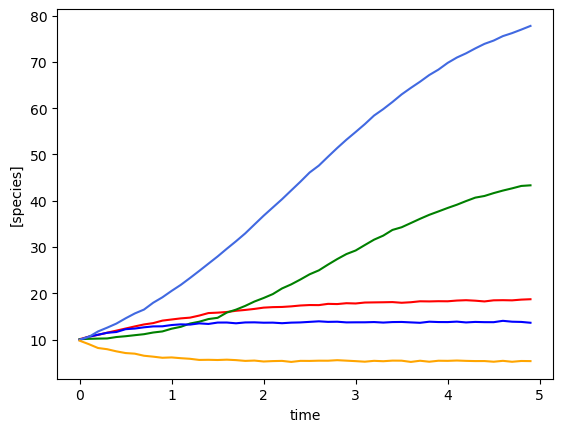

In [2]:
# In this example n >> p and it it is basically same as standard regression
# We have to be careful as most of these gLV models are very weakly identifiable

set_all_seeds(1234)

# SETUP MODEL
# establish size of model
num_species = 5

# construct interaction matrix
# TODO do this programmatically
M = np.zeros((num_species, num_species))
np.fill_diagonal(M, [-0.05, -0.1, -0.15, -0.01, -0.2])
M[0, 2] = -0.025
M[1, 3] = 0.05
M[4, 0] = 0.02

# construct growth rates matrix
mu = np.random.lognormal(0.01, 0.5, num_species)
print(mu.shape)

# instantiate simulator
simulator = sim_gLV(num_species=num_species,
                    M=M,
                    mu=mu)
simulator.print_parameters()

# PRODUCE SIMULATED RESULTS
# initial conditions
init_species = 10 * np.ones(num_species)

times = np.arange(0, 5, 0.1)
yobs, init_species, mu, M, _  = simulator.simulate(times=times, init_species=init_species)

# add some gaussian noise
yobs = yobs + np.random.normal(loc=0, scale=0.1, size=yobs.shape)

# plot simulation
plot_gLV(yobs, times)

### Bayesian inference (no shrinkage)
First we will do Bayesian inference without any shrinkage priors

In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as at
import pickle
import cloudpickle


In [4]:
X, F = linearize_time_course_16S(yobs, times)
print(X.shape)
print(F.shape)

print(X[:10,:])


(49, 6)
(49, 5)
[[10.08871629 10.08595884  9.93634765 10.00156964  9.7757315   1.        ]
 [10.63672501 10.17243118 10.63574052 10.58746926  9.02293081  1.        ]
 [11.02830344 10.21990052 11.05383069 11.76415746  8.1911301   1.        ]
 [11.49668979 10.25315469 11.47239601 12.5847085   7.92746397  1.        ]
 [11.93975123 10.55971572 11.64483214 13.46511305  7.46636016  1.        ]
 [12.39633509 10.73435846 12.2534631  14.60046642  7.09688092  1.        ]
 [12.85231371 10.95788093 12.39165571 15.65227776  6.96453893  1.        ]
 [13.27911657 11.17141819 12.66073899 16.49373703  6.51565046  1.        ]
 [13.56721584 11.53659249 12.85514219 17.97153394  6.31784154  1.        ]
 [14.10505414 11.76928517 12.87720178 19.14263737  6.0791295   1.        ]]


In [15]:
model = pm.Model()
with model:
    
    # Priors for unknown model parameters
    #sigma = pm.HalfNormal('sigma', sigma=1, shape=(5,))  # A separate sigma for each response
    sigma = pm.HalfNormal('sigma', sigma=1, shape=(1,))  # Same sigma for all responses

    mu_hat = pm.HalfNormal('mu_hat', sigma=1, shape=(1, 5))

    #M_hat = pm.Normal('M_hat', mu=0, sigma=0.1, shape=(5, 5))  # tighter prior for the slopes

    # M_ii is constrained to be negative
    M_ii_hat_p = pm.HalfNormal('M_ii_hat_p', sigma=0.1, shape=(5,))  
    M_ii_hat = pm.Deterministic('M_ii_hat', -M_ii_hat_p)

    # M_ij is unconstrained
    M_ij_hat = pm.Normal('M_ij_hat', mu=0, sigma=0.1, shape=(5, 4))  # different shape for off-diagonal

    # Combine values
    M_hat_vals = at.zeros((5, 5))  # start with an all-zero matrix of the correct shape
    M_hat_vals = at.set_subtensor(M_hat_vals[at.arange(5), at.arange(5)], M_ii_hat)  # set diagonal
    M_hat_vals = at.set_subtensor(M_hat_vals[at.arange(5)[:, None], np.delete(np.arange(5), -1)], M_ij_hat)  # set off-diagonal

    # Save the combined matrix as a deterministic variable
    M_hat = pm.Deterministic('M_hat', M_hat_vals)

    # Expected value of outcome (linear model)
    model_mean = pm.math.dot(X, pm.math.concatenate([M_hat_vals, mu_hat], axis=0))

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=model_mean, sigma=sigma, observed=F)

    # Posterior distribution
    idata = pm.sample(1000, tune=1000, chains=4, cores=4)

# print summary
summary = az.summary(idata, var_names=["mu_hat", "M_ii_hat", "M_ij_hat", "M_hat", "sigma"])
print(summary[["mean", "sd", "r_hat"]])

# Write posterior samples to file
az.to_netcdf(idata, 'model_posterior.nc')


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu_hat, M_ii_hat_p, M_ij_hat]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 220 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
/Users/cbarnes/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/cbarnes/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/cbarnes/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/cbarnes/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packa

                 mean     sd  r_hat
mu_hat[0, 0]    0.845  0.601    1.0
mu_hat[0, 1]    0.693  0.519    1.0
mu_hat[0, 2]    0.902  0.591    1.0
mu_hat[0, 3]    0.745  0.527    1.0
mu_hat[0, 4]    1.116  0.108    1.0
M_ii_hat[0]    -0.079  0.061    1.0
M_ii_hat[1]    -0.079  0.059    1.0
M_ii_hat[2]    -0.080  0.060    1.0
M_ii_hat[3]    -0.081  0.060    1.0
M_ii_hat[4]    -0.211  0.018    1.0
M_ij_hat[0, 0] -0.071  0.061    1.0
M_ij_hat[0, 1] -0.011  0.062    1.0
M_ij_hat[0, 2]  0.058  0.063    1.0
M_ij_hat[0, 3]  0.018  0.061    1.0
M_ij_hat[1, 0] -0.003  0.040    1.0
M_ij_hat[1, 1] -0.098  0.040    1.0
M_ij_hat[1, 2]  0.024  0.041    1.0
M_ij_hat[1, 3]  0.019  0.039    1.0
M_ij_hat[2, 0]  0.024  0.059    1.0
M_ij_hat[2, 1]  0.007  0.060    1.0
M_ij_hat[2, 2] -0.140  0.061    1.0
M_ij_hat[2, 3] -0.005  0.059    1.0
M_ij_hat[3, 0]  0.003  0.025    1.0
M_ij_hat[3, 1]  0.049  0.026    1.0
M_ij_hat[3, 2] -0.017  0.026    1.0
M_ij_hat[3, 3] -0.022  0.025    1.0
M_ij_hat[4, 0]  0.010  0.043

'model_posterior.nc'

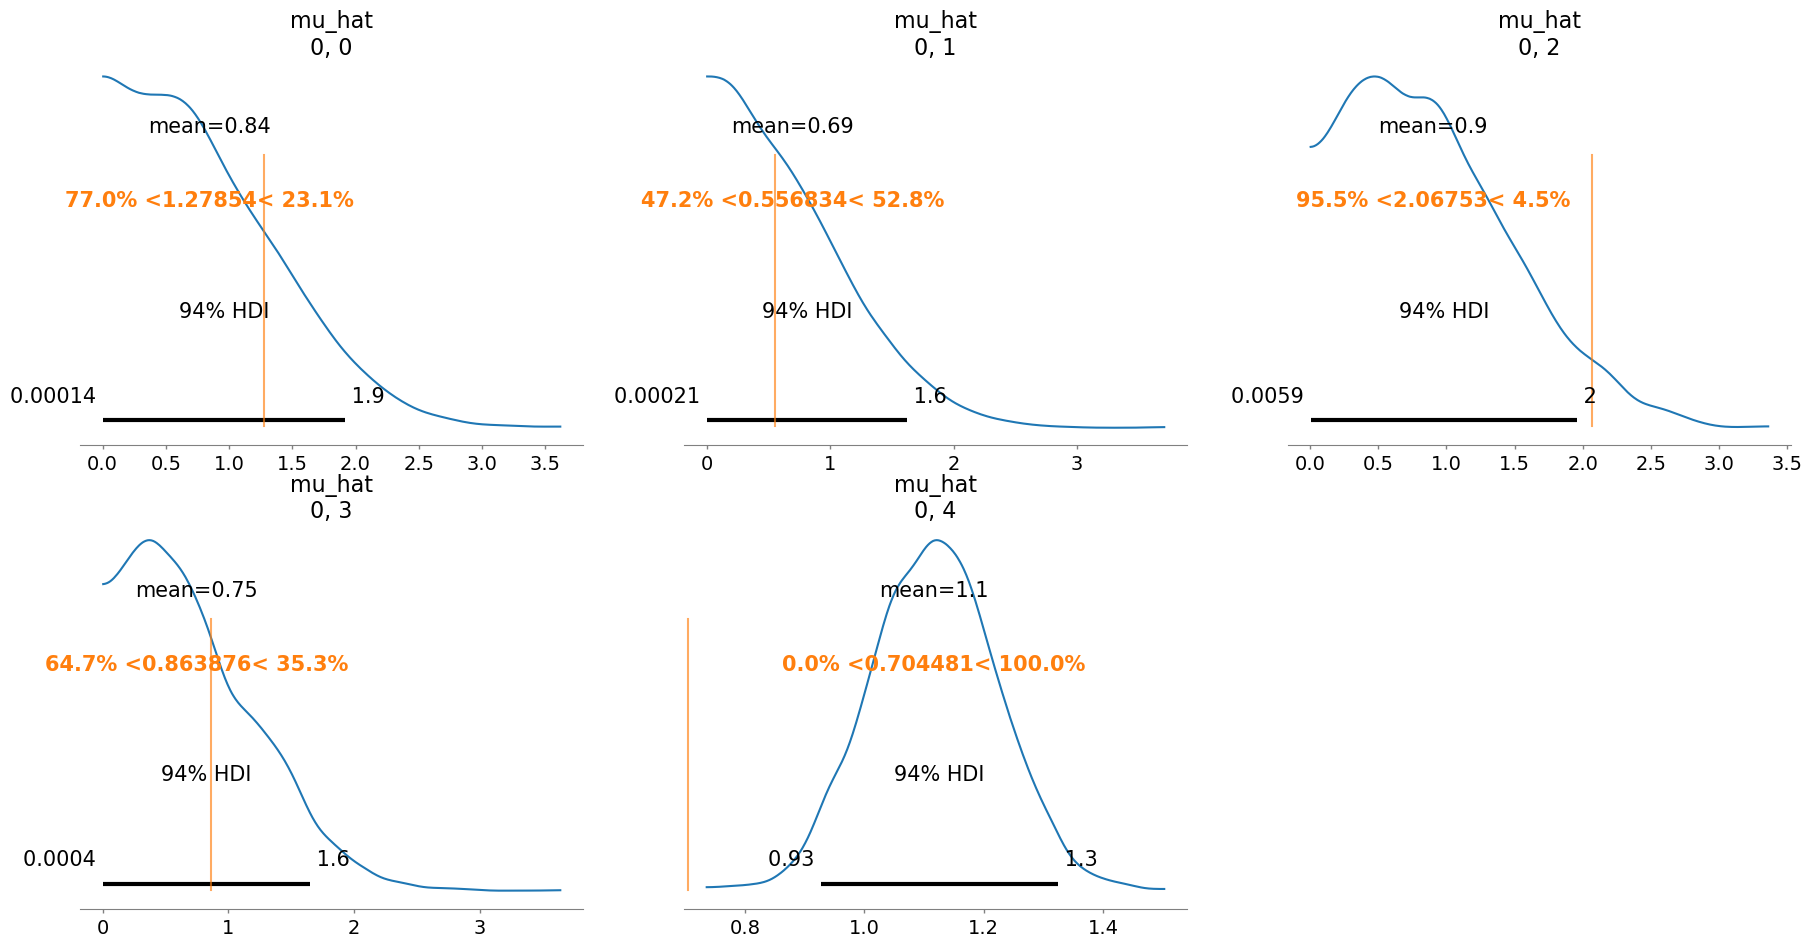

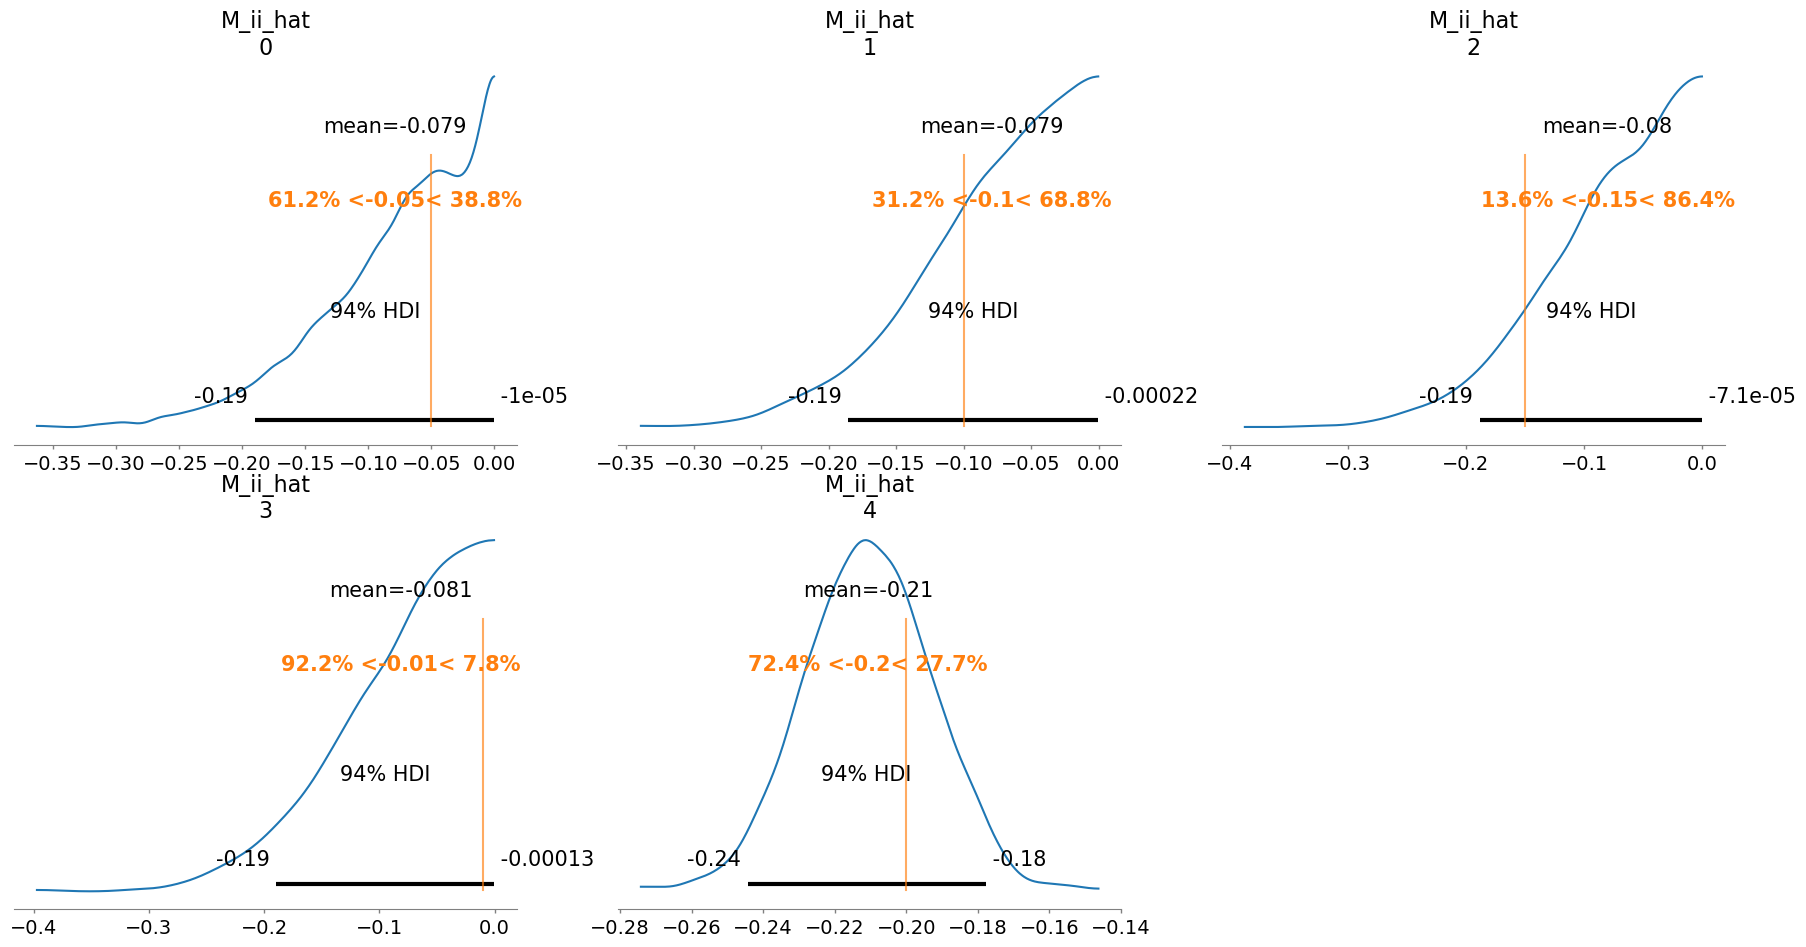

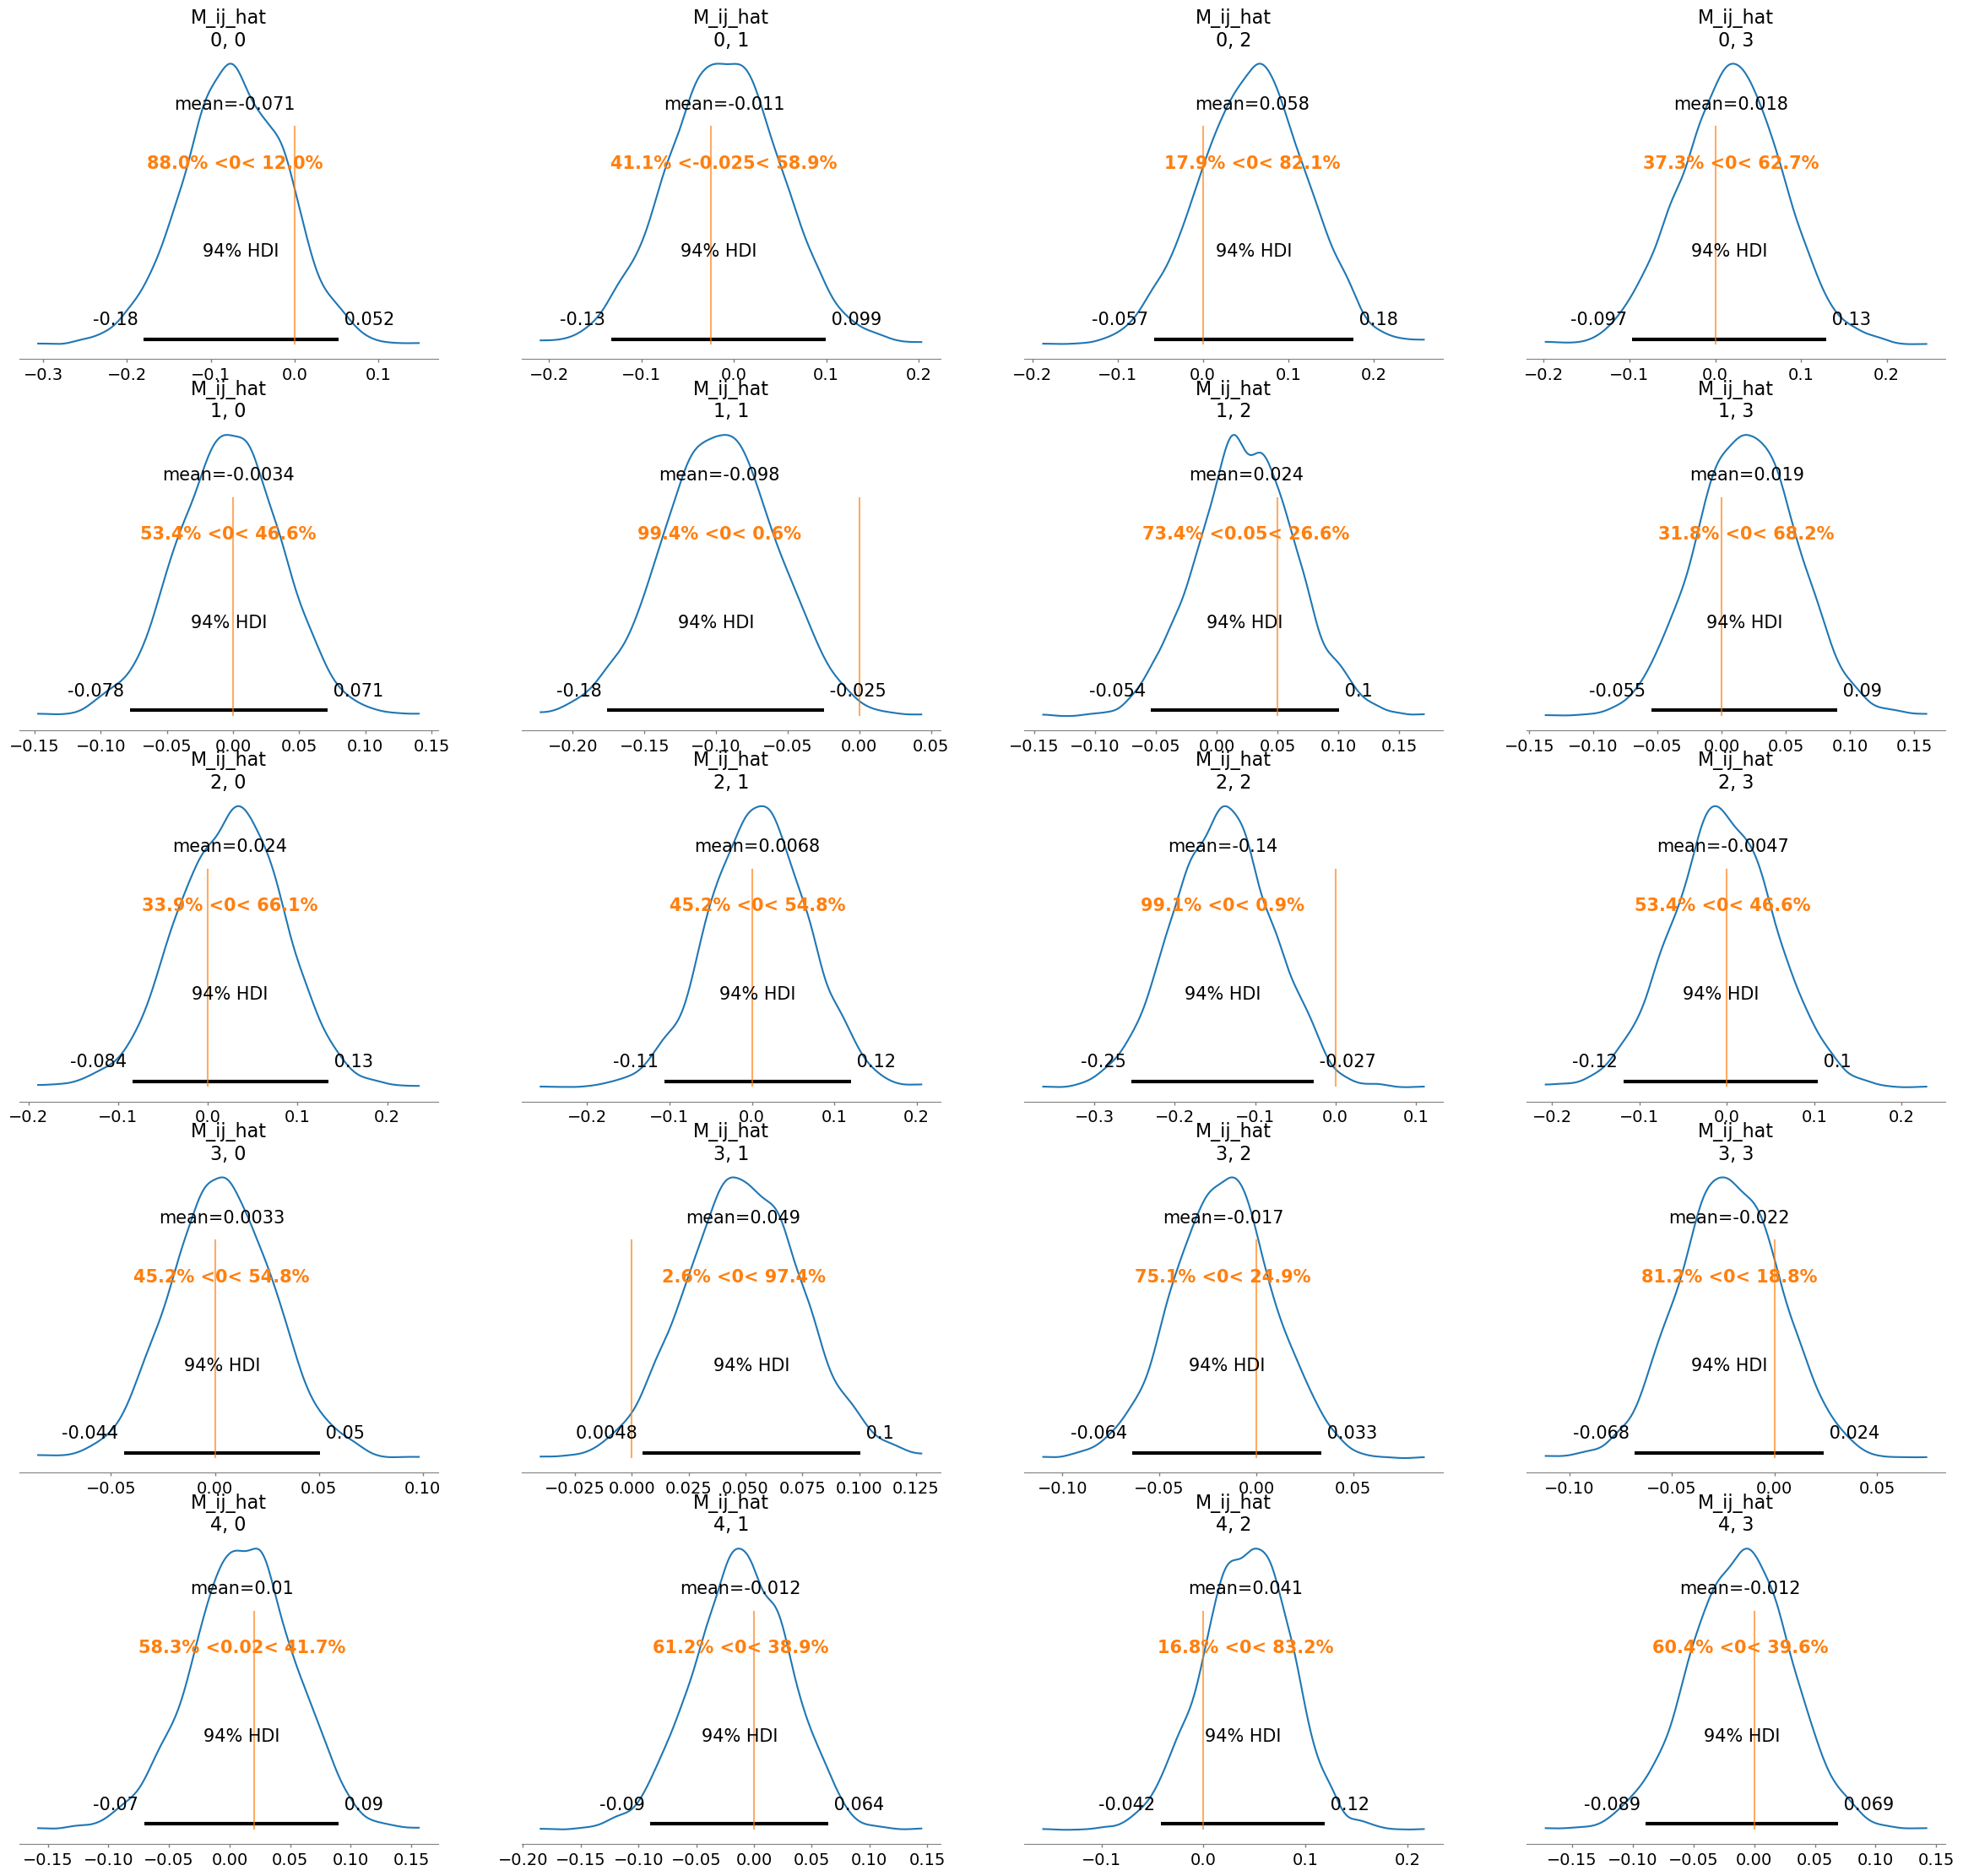

In [16]:
# read in posterior samples
idata = az.from_netcdf('model_posterior.nc')

az.plot_posterior(idata, var_names=["mu_hat"], ref_val=mu.flatten().tolist() )
plt.savefig("plot-posterior-mu.pdf")

az.plot_posterior(idata, var_names=["M_ii_hat"], ref_val=np.diag(M).tolist() )
plt.savefig("plot-posterior-Mii.pdf")

mask = ~np.eye(M.shape[0], dtype=bool)
M_ij = M[mask]
az.plot_posterior(idata, var_names=["M_ij_hat"], ref_val=M_ij.flatten().tolist() )
plt.savefig("plot-posterior-Mij.pdf")



(4, 1000, 5, 5)
(4, 1000, 1, 5)
Using the following parameters for gLV simulation: {'num_species': 5, 'mu': array([0.74629916, 0.59052084, 0.82790503, 0.64499108, 1.11569745]), 'M': array([[-0.07214357, -0.0113509 ,  0.05979015,  0.01890131,  0.        ],
       [-0.00324056, -0.09789194,  0.02379836,  0.01932384,  0.        ],
       [ 0.02633929,  0.00734007, -0.1404929 , -0.00559798,  0.        ],
       [ 0.00332325,  0.04903467, -0.01689799, -0.02230938,  0.        ],
       [ 0.01061574, -0.01114356,  0.0428441 , -0.01075916, -0.21068539]]), 'epsilon': array([], shape=(5, 0), dtype=float64)}
mu_hat/mu:
[0.74629916 0.59052084 0.82790503 0.64499108 1.11569745]
[1.27853844 0.55683415 2.06752757 0.86387608 0.70448068]

M_hat/M:
[[-0.07 -0.01  0.06  0.02  0.  ]
 [-0.   -0.1   0.02  0.02  0.  ]
 [ 0.03  0.01 -0.14 -0.01  0.  ]
 [ 0.    0.05 -0.02 -0.02  0.  ]
 [ 0.01 -0.01  0.04 -0.01 -0.21]]

 [[-0.05   0.    -0.025  0.     0.   ]
 [ 0.    -0.1    0.     0.05   0.   ]
 [ 0.     0.    

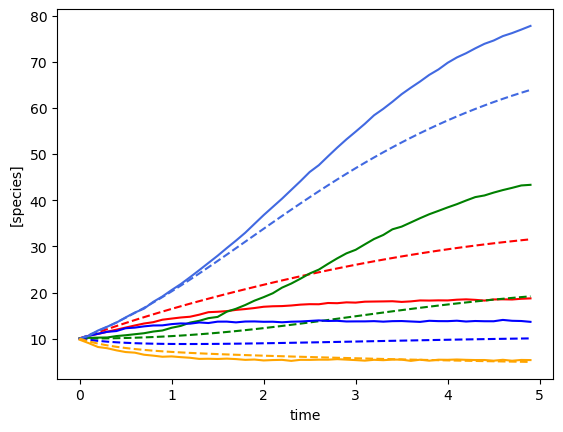

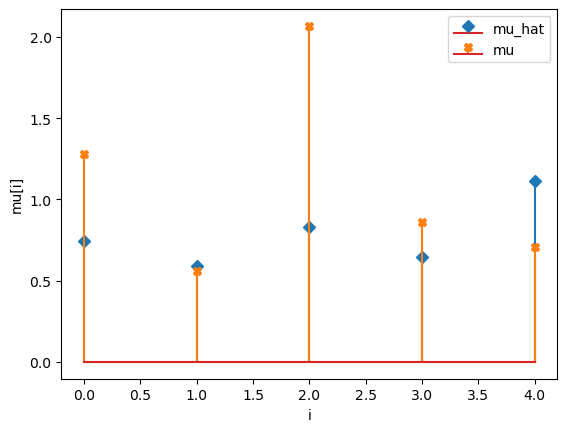

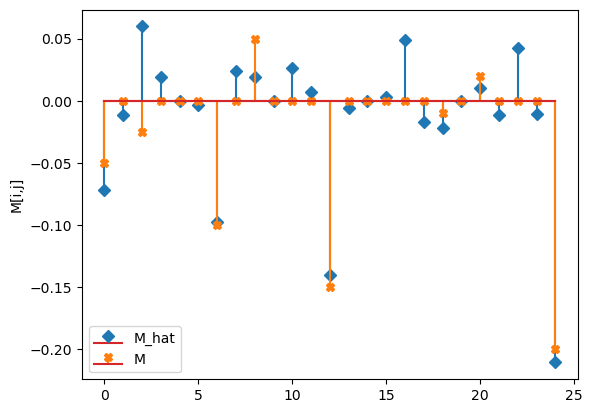

In [17]:
# 4 chains x 100 draws x 5 x 5 species
print( idata.posterior["M_hat"].values.shape )

print( idata.posterior["mu_hat"].values.shape )

# # get median posterior values   
M_h = np.median(idata.posterior["M_hat"].values, axis=(0,1))

mu_h = np.median(idata.posterior["mu_hat"].values, axis=(0, 1))
mu_h = mu_h.flatten()

predictor = sim_gLV(num_species=num_species,
                    M=M_h,
                    mu=mu_h
                 )
yobs_h, _, _, _, _ = predictor.simulate(times=times, init_species=init_species)

plot_fit_gLV(yobs, yobs_h, times)
compare_params(mu=(mu, mu_h), M=(M, M_h) )


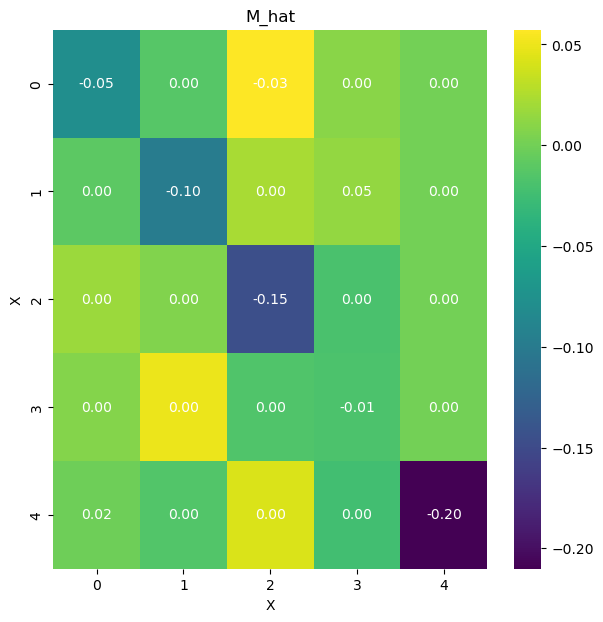

In [13]:
# visualize the interaction matrix
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

# Heatmap for M_hat
sns.heatmap(M_h, ax=ax, cmap='viridis')
ax.set_title('M_hat')
ax.set_ylabel('X')
ax.set_xlabel('X')

# Annotate the true values for matrix1
for i in range(M_h.shape[0]):
    for j in range(M_h.shape[1]):
        ax.text(j + 0.5, i + 0.5, f'{M[i, j]:.2f}', ha='center', va='center', color='white')

### Bayesian inference with shrinkage
Now we will do inference with the Horseshoe prior

In [32]:
nX = num_species
n_obs = times.shape[0] - 1
noise_stddev = 0.1

# Params for shrinkage on M_ij (non diagonal elements)
DA = nX*nX - nX
DA0 = 3     # expected number of non zero entries in M_ij
N = n_obs - 2

model = pm.Model()
with model:
    sigma = pm.HalfNormal('sigma', sigma=1, shape=(1,))  # Same sigma for all responses

    #mu_hat = pm.HalfNormal('mu_hat', sigma=1, shape=(1, 5))
    mu_hat = pm.TruncatedNormal('mu_hat', mu=1.0, sigma=0.5, lower=0, shape=(1, 5))

    # M_ii is constrained to be negative
    #M_ii_hat_p = pm.HalfNormal('M_ii_hat_p', sigma=0.1, shape=(5,))  
    #M_ii_hat = pm.Deterministic('M_ii_hat', -M_ii_hat_p)
    M_ii_hat = pm.TruncatedNormal('M_ii_hat', mu=-0.1, sigma=0.1, upper=0, shape=(5,))
    
    # M_ij is is unconstrained but placed under horseshoe prior
    tau0 = (DA0 / (DA - DA0)) * noise_stddev / np.sqrt(N)
    c2 = pm.InverseGamma("c2", 2, 1)
    tau = pm.HalfCauchy("tau", beta=tau0)
    lam = pm.HalfCauchy("lam", beta=1, shape=(5, 4) )
    M_ij_hat = pm.Normal('M_ij_hat', mu=0, sigma = tau * lam*at.sqrt(c2 / (c2 + tau**2 * lam**2)), shape=(5, 4) )

    # Combine values
    M_hat_vals = at.zeros((5, 5))  # start with an all-zero matrix of the correct shape
    M_hat_vals = at.set_subtensor(M_hat_vals[at.arange(5), at.arange(5)], M_ii_hat)  # set diagonal
    M_hat_vals = at.set_subtensor(M_hat_vals[at.arange(5)[:, None], np.delete(np.arange(5), -1)], M_ij_hat)  # set off-diagonal

    # Save the combined matrix as a deterministic variable
    M_hat = pm.Deterministic('M_hat', M_hat_vals)

    # Expected value of outcome (linear model)
    model_mean = pm.math.dot(X, pm.math.concatenate([M_hat_vals, mu_hat], axis=0))

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=model_mean, sigma=sigma, observed=F)

    # Posterior distribution
    idata = pm.sample(1000, tune=2000, chains=4, cores=4)

# print summary
summary = az.summary(idata, var_names=["mu_hat", "M_ii_hat", "M_ij_hat", "M_hat", "sigma"])
print(summary[["mean", "sd", "r_hat"]])

# Write posterior samples to file
az.to_netcdf(idata, 'model_posterior.nc')


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu_hat, M_ii_hat, c2, tau, lam, M_ij_hat]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 248 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 676 divergences after tuning. Increase `target_accept` or reparameterize.
/Users/cbarnes/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/cbarnes/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_s

                 mean     sd  r_hat
mu_hat[0, 0]    0.916  0.309   1.02
mu_hat[0, 1]    0.723  0.337   1.02
mu_hat[0, 2]    1.403  0.440   1.02
mu_hat[0, 3]    0.917  0.201   1.01
mu_hat[0, 4]    1.129  0.110   1.03
M_ii_hat[0]    -0.127  0.075   1.01
M_ii_hat[1]    -0.135  0.084   1.03
M_ii_hat[2]    -0.131  0.082   1.00
M_ii_hat[3]    -0.122  0.079   1.02
M_ii_hat[4]    -0.213  0.019   1.04
M_ij_hat[0, 0] -0.039  0.025   1.02
M_ij_hat[0, 1]  0.003  0.017   1.03
M_ij_hat[0, 2] -0.003  0.022   1.04
M_ij_hat[0, 3] -0.002  0.010   1.03
M_ij_hat[1, 0]  0.002  0.009   1.01
M_ij_hat[1, 1] -0.070  0.035   1.01
M_ij_hat[1, 2]  0.004  0.011   1.07
M_ij_hat[1, 3] -0.004  0.009   1.03
M_ij_hat[2, 0] -0.010  0.027   1.01
M_ij_hat[2, 1] -0.001  0.015   1.03
M_ij_hat[2, 2] -0.101  0.042   1.01
M_ij_hat[2, 3] -0.002  0.013   1.02
M_ij_hat[3, 0] -0.002  0.006   1.02
M_ij_hat[3, 1]  0.033  0.020   1.01
M_ij_hat[3, 2] -0.002  0.007   1.07
M_ij_hat[3, 3] -0.008  0.005   1.02
M_ij_hat[4, 0]  0.003  0.013

'model_posterior.nc'

mu_hat/mu:
[0.92487712 0.65542717 1.43083117 0.90579377 1.12850634]
[1.27853844 0.55683415 2.06752757 0.86387608 0.70448068]

M_hat/M:
[[-0.04  0.   -0.   -0.    0.  ]
 [ 0.   -0.08  0.   -0.    0.  ]
 [-0.   -0.   -0.1  -0.    0.  ]
 [-0.    0.04 -0.   -0.01  0.  ]
 [ 0.   -0.01  0.   -0.   -0.21]]

 [[-0.05   0.    -0.025  0.     0.   ]
 [ 0.    -0.1    0.     0.05   0.   ]
 [ 0.     0.    -0.15   0.     0.   ]
 [ 0.     0.     0.    -0.01   0.   ]
 [ 0.02   0.     0.     0.    -0.2  ]]
Using the following parameters for gLV simulation: {'num_species': 5, 'mu': array([0.92487712, 0.65542717, 1.43083117, 0.90579377, 1.12850634]), 'M': array([[-4.05267724e-02,  5.17187567e-04, -2.20714411e-04,
        -3.05284829e-04,  0.00000000e+00],
       [ 3.58473637e-04, -7.74000997e-02,  3.69698554e-04,
        -1.55588631e-03,  0.00000000e+00],
       [-2.58727823e-03, -1.28668854e-04, -1.03025177e-01,
        -1.41082560e-04,  0.00000000e+00],
       [-7.89513592e-04,  3.73440373e-02, -3.91146

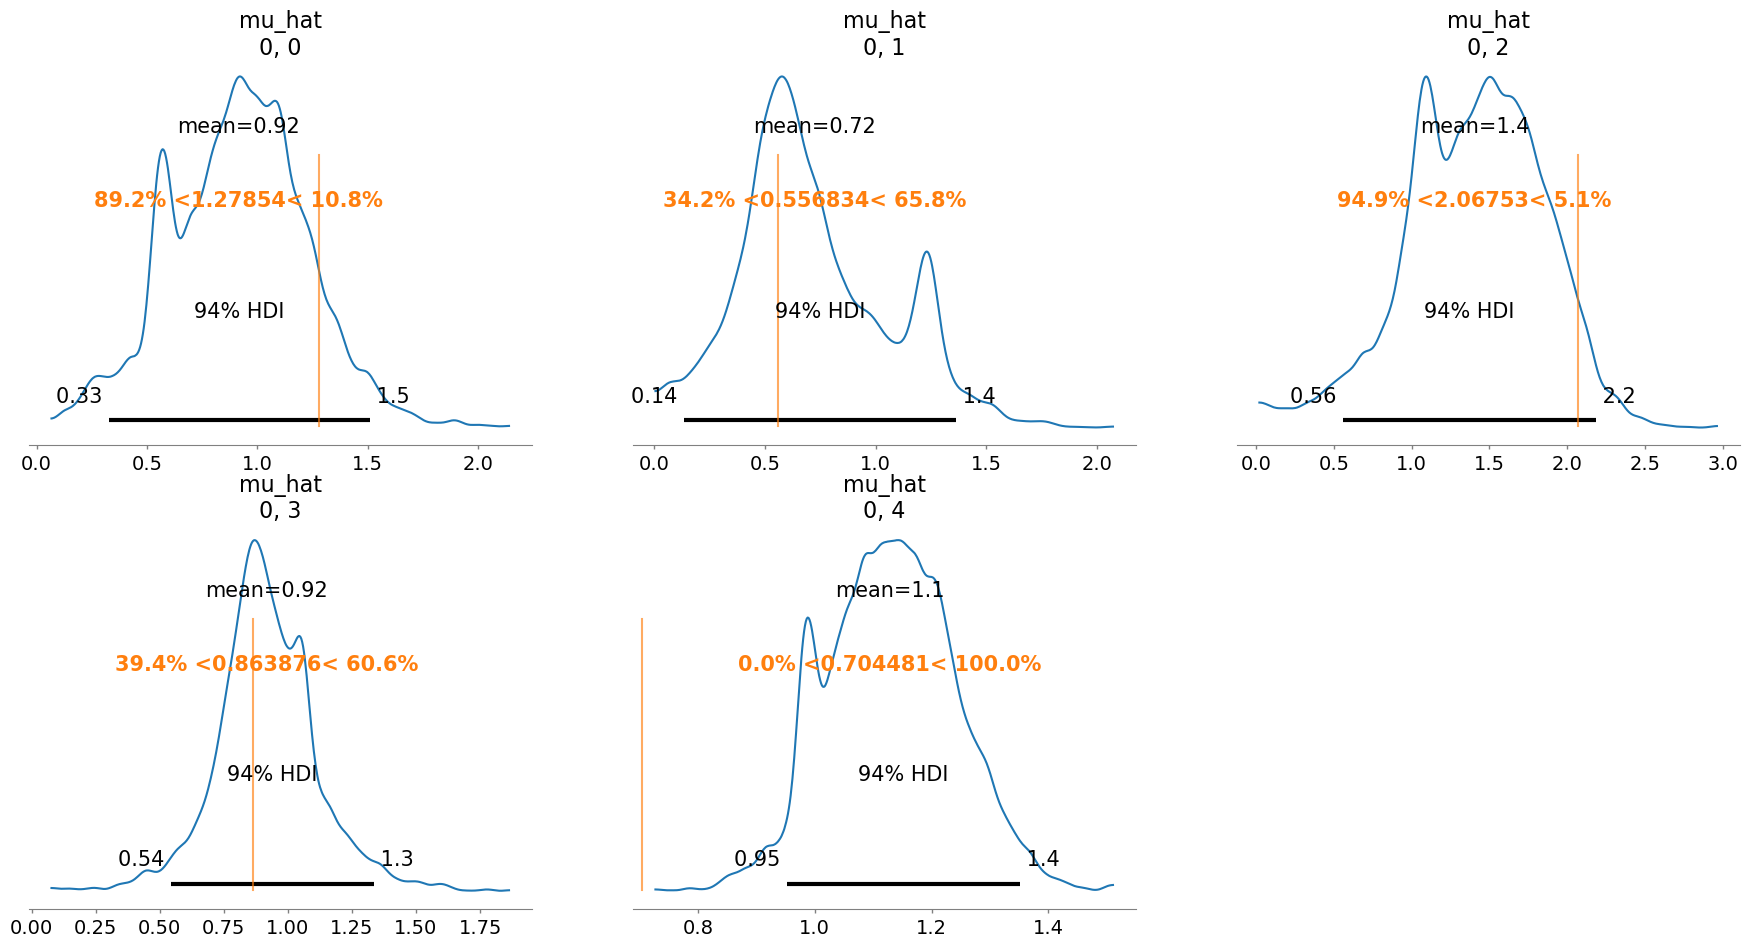

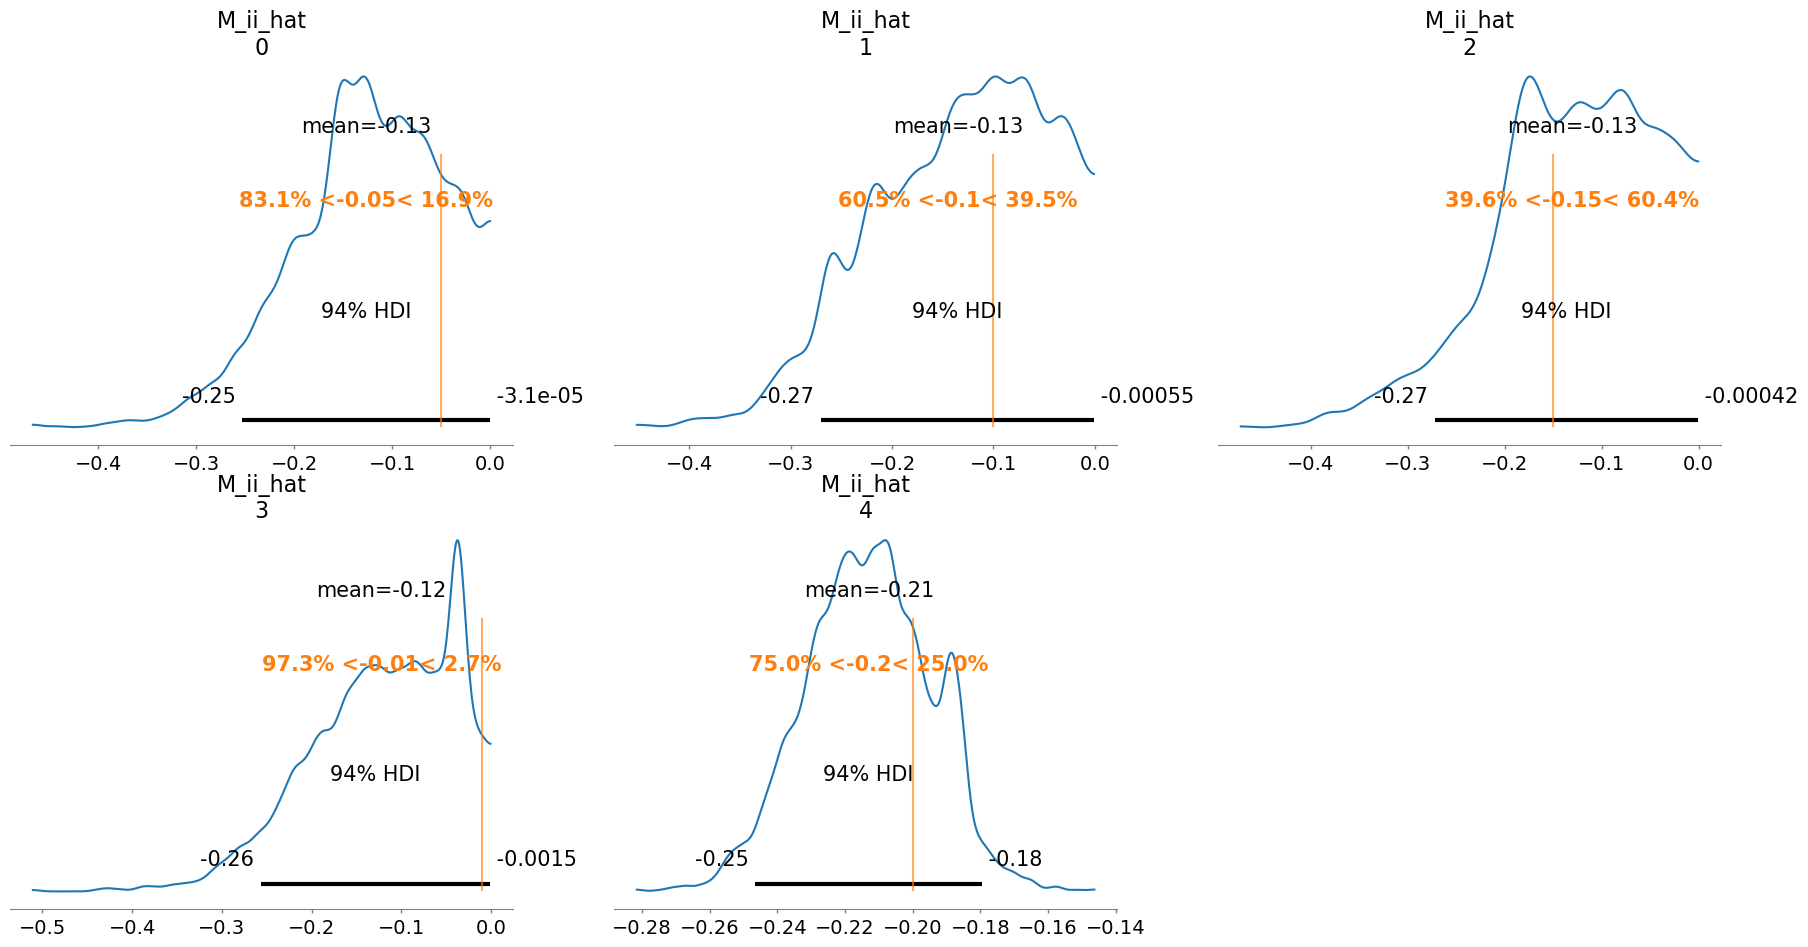

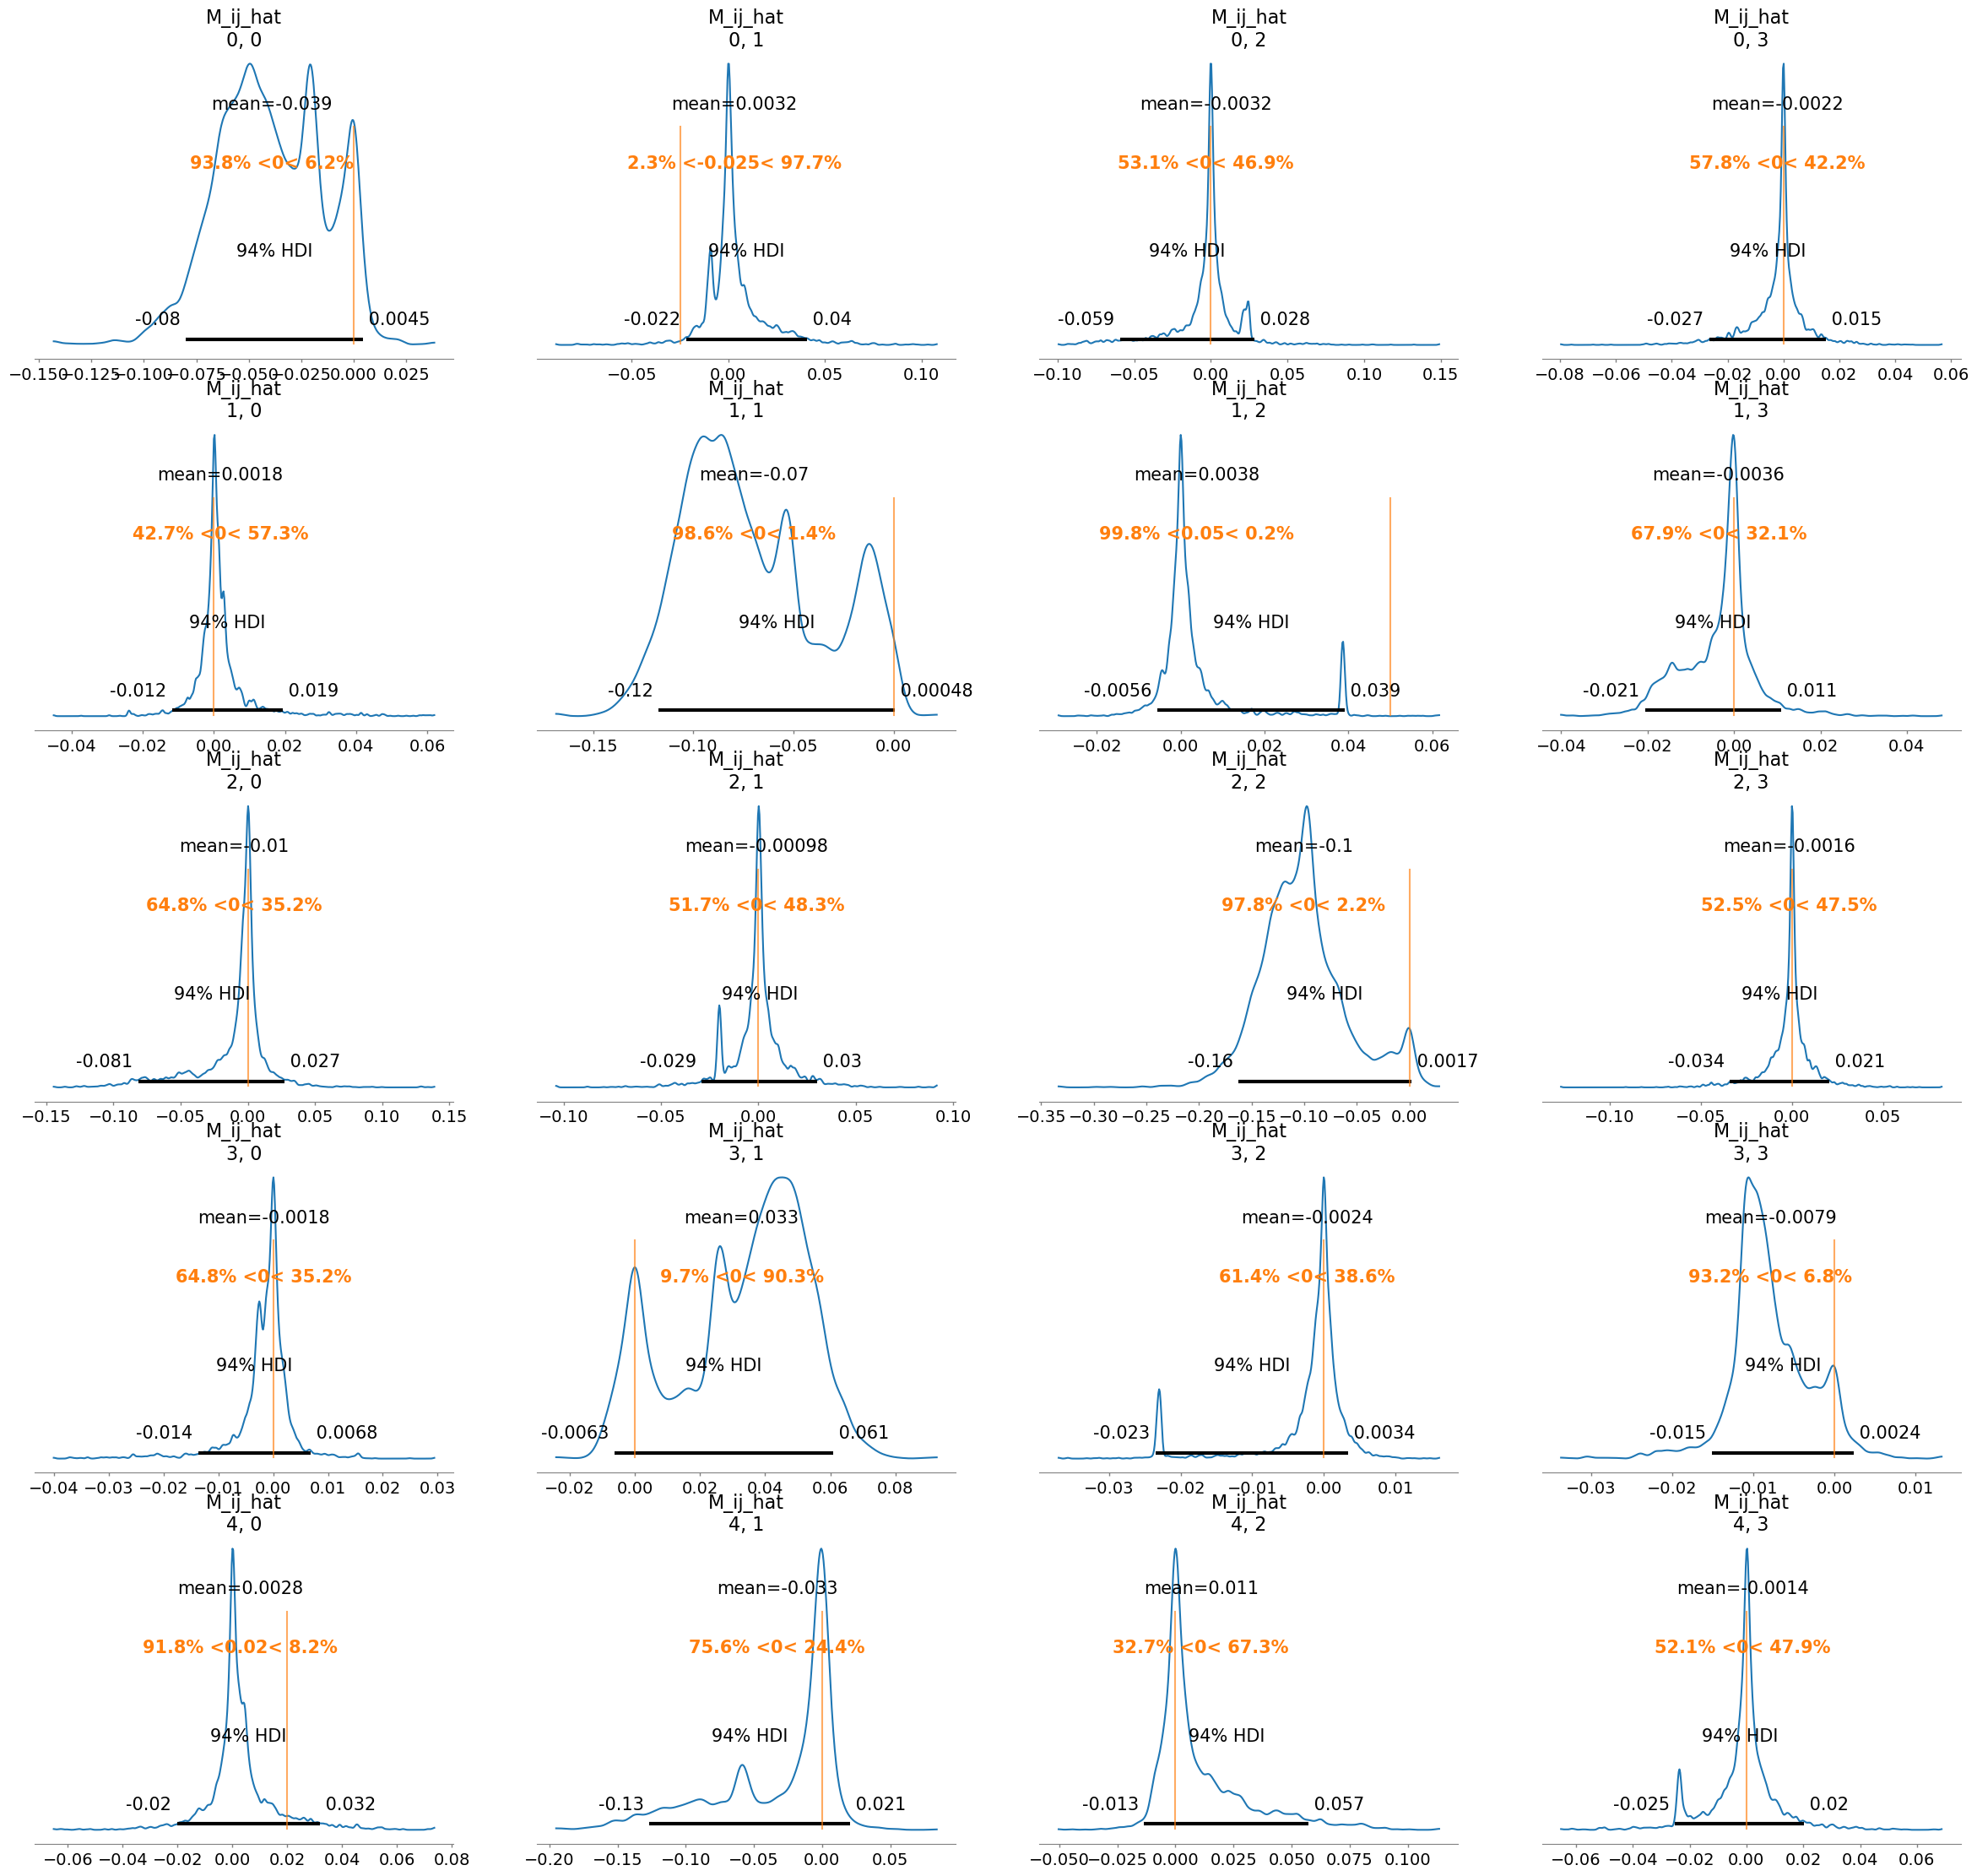

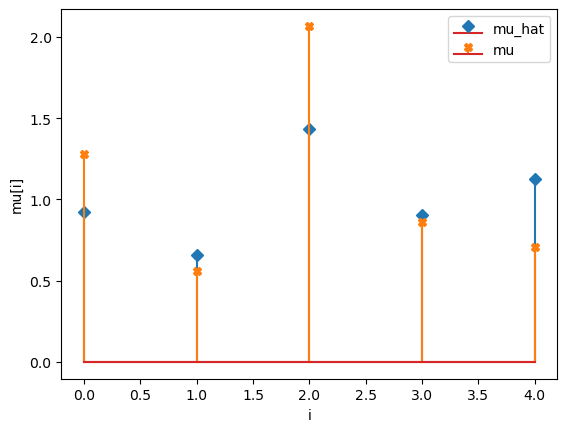

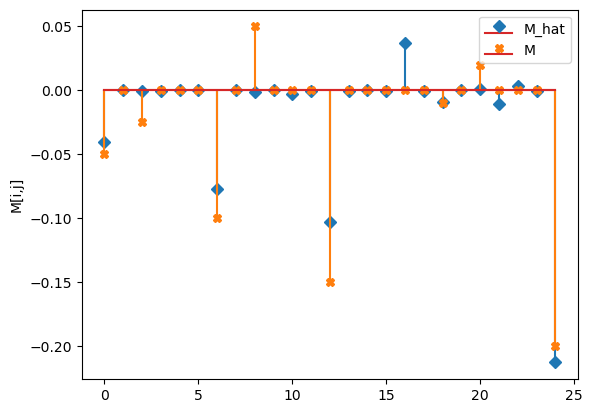

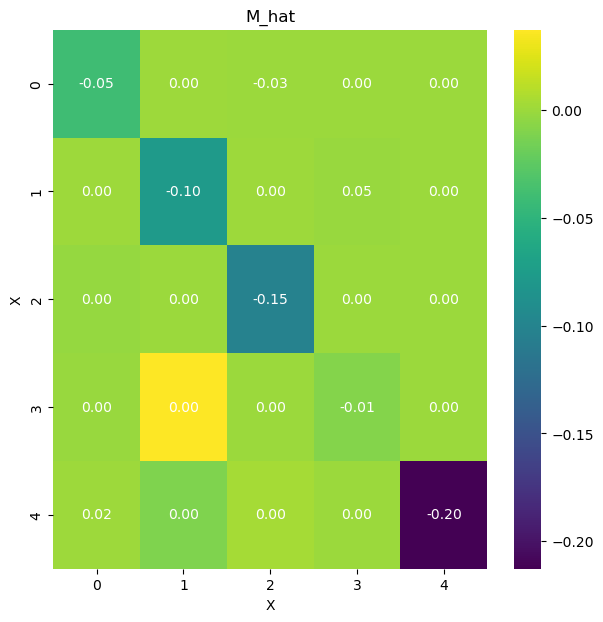

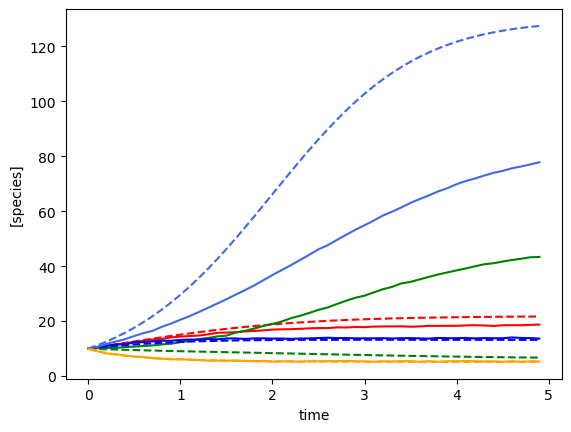

In [33]:
# read in posterior samples
idata = az.from_netcdf('model_posterior.nc')

az.plot_posterior(idata, var_names=["mu_hat"], ref_val=mu.flatten().tolist() )
plt.savefig("plot-posterior-mu.pdf")

az.plot_posterior(idata, var_names=["M_ii_hat"], ref_val=np.diag(M).tolist() )
plt.savefig("plot-posterior-Mii.pdf")

mask = ~np.eye(M.shape[0], dtype=bool)
M_ij = M[mask]
az.plot_posterior(idata, var_names=["M_ij_hat"], ref_val=M_ij.flatten().tolist() )
plt.savefig("plot-posterior-Mij.pdf")

# get posterior medians
M_h = np.median(idata.posterior["M_hat"].values, axis=(0,1))

mu_h = np.median(idata.posterior["mu_hat"].values, axis=(0, 1))
mu_h = mu_h.flatten()

# compare median posterior values to true values
compare_params(mu=(mu, mu_h), M=(M, M_h) )

# visualize the interaction matrix
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sns.heatmap(M_h, ax=ax, cmap='viridis')
ax.set_title('M_hat')
ax.set_ylabel('X')
ax.set_xlabel('X')
# Annotate the true values 
for i in range(M_h.shape[0]):
    for j in range(M_h.shape[1]):
        ax.text(j + 0.5, i + 0.5, f'{M[i, j]:.2f}', ha='center', va='center', color='white')


# Look at fit
predictor = sim_gLV(num_species=num_species,
                    M=M_h,
                    mu=mu_h
                 )
yobs_h, _, _, _, _ = predictor.simulate(times=times, init_species=init_species)
plot_fit_gLV(yobs, yobs_h, times)


### Bayesian inference with shrinkage and a perturbation with unknown interactions
Now we will do inference with the Horseshoe prior for shrinkage but now we include a perturbation (assuming unknown interaction terms). This gives more identifiability

perturbation:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 0 0 0]
Model parameters:
Model: gLV
num_species: 5
mu: [1.28 0.56 2.07 0.86 0.7 ]
M: [[-0.05  0.   -0.03  0.    0.  ]
 [ 0.   -0.1   0.    0.05  0.  ]
 [ 0.    0.   -0.15  0.    0.  ]
 [ 0.    0.    0.   -0.01  0.  ]
 [ 0.02  0.    0.    0.   -0.2 ]]
epsilon: [[ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]]
Using the following parameters for gLV simulation: {'num_species': 5, 'mu': array([1.27853844, 0.55683415, 2.06752757, 0.86387608, 0.70448068]), 'M': array([[-0.05 ,  0.   , -0.025,  0.   ,  0.   ],
       [ 0.   , -0.1  ,  0.   ,  0.05 ,  0.   ],
       [ 0.   ,  0.   , -0.15 ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , -0.01 ,  0.   ],
       [ 0.02 ,  0.   ,  0.   ,  0.   , -0.2  ]]), 'epsilon': array([[ 1.],
       [-1.],
       [ 1.],
       [-1.],
       [ 1.]])}


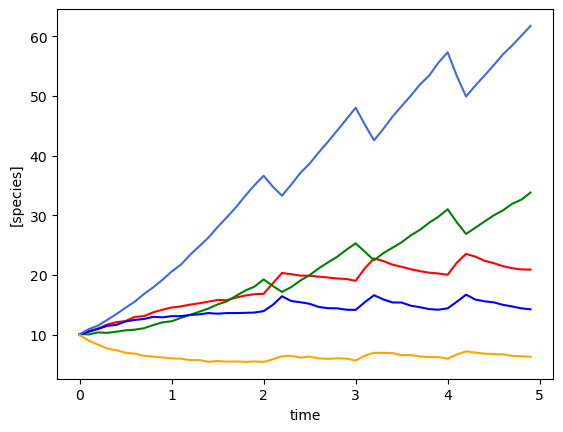

In [38]:
# use all previous definitions of mu, M etc

# construct perturbation matrix
num_perturbations = 1
epsilon = np.zeros([num_species, num_perturbations])
epsilon[:, 0] = [1, -1, 1, -1, 1]

def pert_fn(t):
    if 2.0 <= t < 2.2 or 3.0 <= t < 3.2 or 4.0 <= t < 4.2:
        return np.array([1])
    else: 
        return np.array([0])

# relinearise
u = np.array([pert_fn(t)[0] for t in times])
u = u.astype(int)
print('perturbation:\n', u)

X, F = linearize_time_course_16S_u(yobs, times, u)

# instantiate simulator
simulator = sim_gLV(num_species=num_species,
                    num_perturbations=num_perturbations,
                    M=M,
                    mu=mu,
                    epsilon=epsilon)
simulator.print_parameters()

yobs, init_species, mu, M, _  = simulator.simulate(times=times, init_species=init_species, u=pert_fn)

# add some gaussian noise
yobs = yobs + np.random.normal(loc=0, scale=0.1, size=yobs.shape)

# plot simulation
plot_gLV(yobs, times)

In [53]:
nX = num_species
n_obs = times.shape[0] - 1
noise_stddev = 0.1

# Params for shrinkage on M_ij (non diagonal elements)
DA = nX*nX - nX
DA0 = 3     # expected number of non zero entries in M_ij
N = n_obs - 2

model = pm.Model()
with model:
    sigma = pm.HalfNormal('sigma', sigma=1, shape=(1,))  # Same sigma for all responses

    mu_hat = pm.TruncatedNormal('mu_hat', mu=1.0, sigma=0.5, lower=0, shape=(1, 5))

    epsilon_hat = pm.Normal('epsilon_hat', mu=0, sigma=1.0, shape=(1, 5))

    # M_ii is constrained to be negative
    M_ii_hat = pm.TruncatedNormal('M_ii_hat', mu=-0.1, sigma=0.1, upper=0, shape=(5,))
    
    # M_ij is is unconstrained but placed under horseshoe prior
    tau0 = (DA0 / (DA - DA0)) * noise_stddev / np.sqrt(N)
    c2 = pm.InverseGamma("c2", 2, 1)
    tau = pm.HalfCauchy("tau", beta=tau0)
    lam = pm.HalfCauchy("lam", beta=1, shape=(5, 4) )
    M_ij_hat = pm.Normal('M_ij_hat', mu=0, sigma = tau * lam*at.sqrt(c2 / (c2 + tau**2 * lam**2)), shape=(5, 4) )

    # Combine values
    M_hat_vals = at.zeros((5, 5))  # start with an all-zero matrix of the correct shape
    M_hat_vals = at.set_subtensor(M_hat_vals[at.arange(5), at.arange(5)], M_ii_hat)  # set diagonal
    M_hat_vals = at.set_subtensor(M_hat_vals[at.arange(5)[:, None], np.delete(np.arange(5), -1)], M_ij_hat)  # set off-diagonal

    # Save the combined interaction matrix as a deterministic variable
    M_hat = pm.Deterministic('M_hat', M_hat_vals)

    # Expected value of outcome (linear model)
    model_mean = pm.math.dot(X, pm.math.concatenate([M_hat_vals, mu_hat, epsilon_hat], axis=0))

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=model_mean, sigma=sigma, observed=F)

    # Posterior distribution
    idata = pm.sample(1000, tune=2000, chains=4, cores=4)

# print summary
summary = az.summary(idata, var_names=["mu_hat", "M_hat", "epsilon_hat", "sigma"])
print(summary[["mean", "sd", "r_hat"]])

# Write posterior samples to file
az.to_netcdf(idata, 'model_posterior.nc')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu_hat, epsilon_hat, M_ii_hat, c2, tau, lam, M_ij_hat]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 227 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 515 divergences after tuning. Increase `target_accept` or reparameterize.
/Users/cbarnes/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/cbarnes/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_s

                    mean     sd  r_hat
mu_hat[0, 0]       1.048  0.180   1.01
mu_hat[0, 1]       0.692  0.235   1.00
mu_hat[0, 2]       1.479  0.326   1.02
mu_hat[0, 3]       0.896  0.143   1.01
mu_hat[0, 4]       1.191  0.129   1.00
M_hat[0, 0]       -0.049  0.018   1.01
M_hat[0, 1]        0.008  0.013   1.00
M_hat[0, 2]       -0.015  0.025   1.02
M_hat[0, 3]       -0.002  0.008   1.00
M_hat[0, 4]        0.000  0.000    NaN
M_hat[1, 0]        0.000  0.006   1.00
M_hat[1, 1]       -0.035  0.041   1.02
M_hat[1, 2]        0.002  0.007   1.02
M_hat[1, 3]       -0.005  0.009   1.01
M_hat[1, 4]        0.000  0.000    NaN
M_hat[2, 0]       -0.008  0.023   1.00
M_hat[2, 1]        0.007  0.016   1.01
M_hat[2, 2]       -0.093  0.044   1.02
M_hat[2, 3]       -0.001  0.011   1.01
M_hat[2, 4]        0.000  0.000    NaN
M_hat[3, 0]       -0.001  0.004   1.01
M_hat[3, 1]        0.016  0.021   1.02
M_hat[3, 2]       -0.000  0.004   1.01
M_hat[3, 3]       -0.007  0.005   1.00
M_hat[3, 4]        0.000 

'model_posterior.nc'

mu_hat/mu:
[1.03338198 0.6832151  1.5233694  0.89298001 1.19070002]
[1.27853844 0.55683415 2.06752757 0.86387608 0.70448068]

M_hat/M:
[[-0.05  0.   -0.   -0.    0.  ]
 [-0.   -0.01  0.   -0.    0.  ]
 [-0.    0.   -0.11 -0.    0.  ]
 [-0.    0.   -0.   -0.01  0.  ]
 [ 0.   -0.08  0.    0.   -0.22]]

 [[-0.05   0.    -0.025  0.     0.   ]
 [ 0.    -0.1    0.     0.05   0.   ]
 [ 0.     0.    -0.15   0.     0.   ]
 [ 0.     0.     0.    -0.01   0.   ]
 [ 0.02   0.     0.     0.    -0.2  ]]

e_hat/e:
[[ 0.93]
 [-0.99]
 [ 0.83]
 [-0.97]
 [ 0.97]]

 [[ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]]
epsilon: [[ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]]
epsilon_h: [[ 0.93483996]
 [-0.98962994]
 [ 0.8267046 ]
 [-0.9743162 ]
 [ 0.96534547]]
Using the following parameters for gLV simulation: {'num_species': 5, 'mu': array([1.27853844, 0.55683415, 2.06752757, 0.86387608, 0.70448068]), 'M': array([[-0.05 ,  0.   , -0.025,  0.   ,  0.   ],
       [ 0.   , -0.1  ,  0.   ,  0.05 ,  0.   ],
       [ 0.   ,  0.   , -0.15 , 

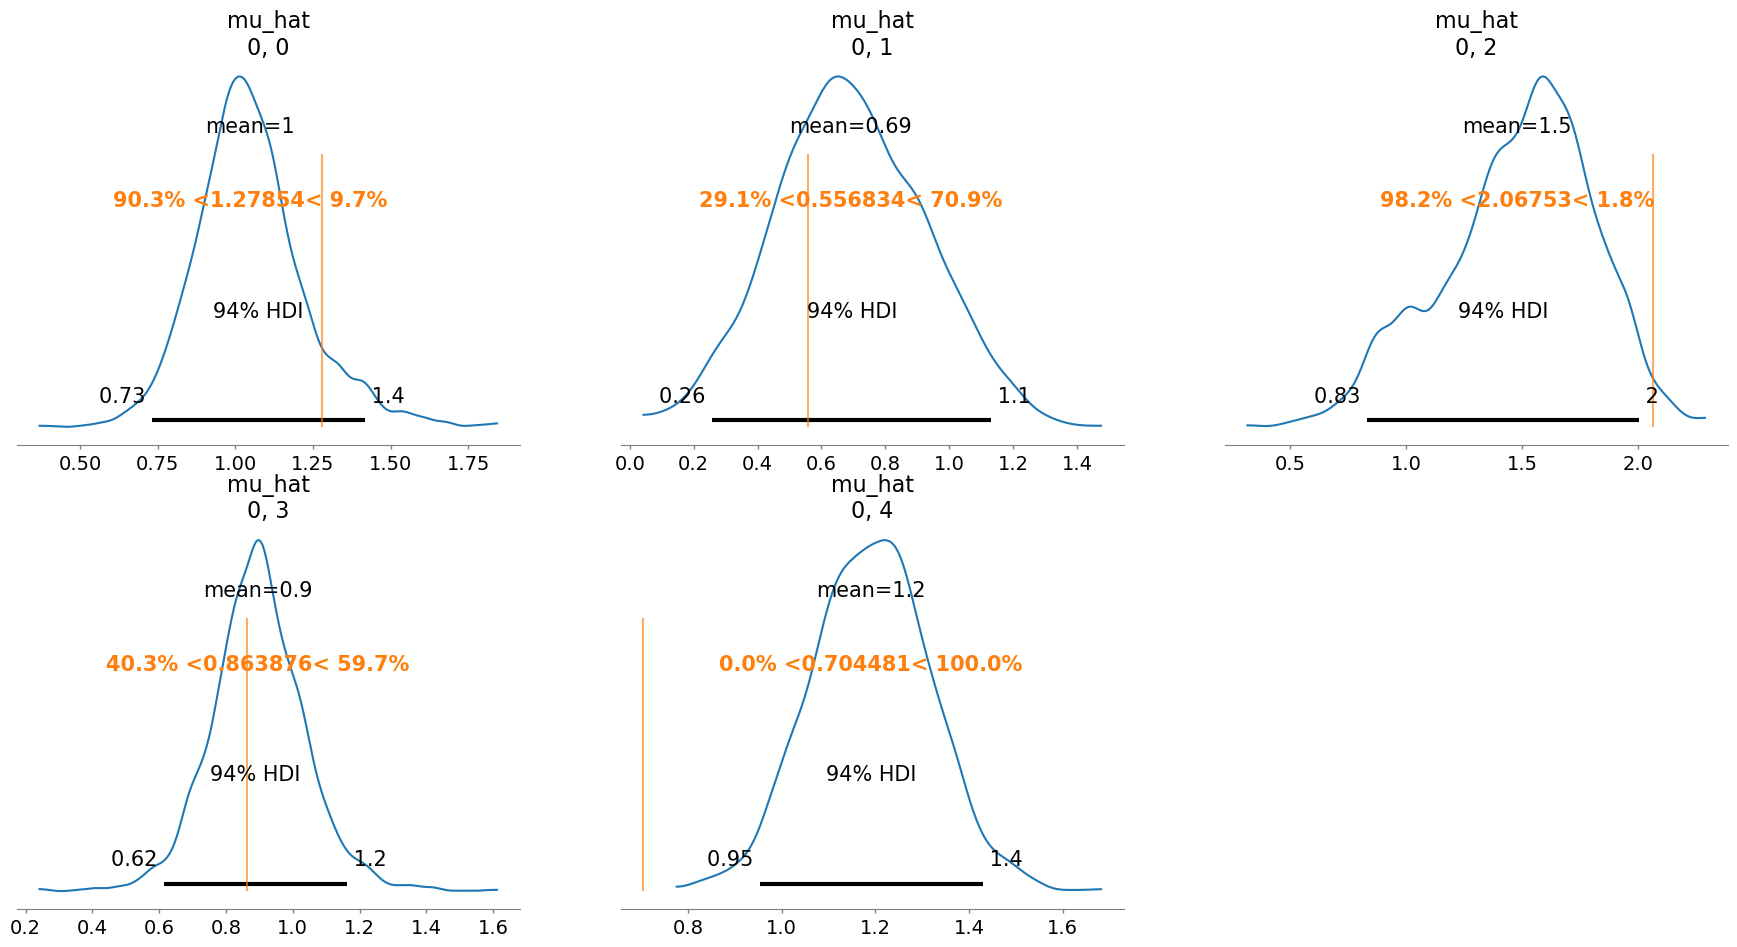

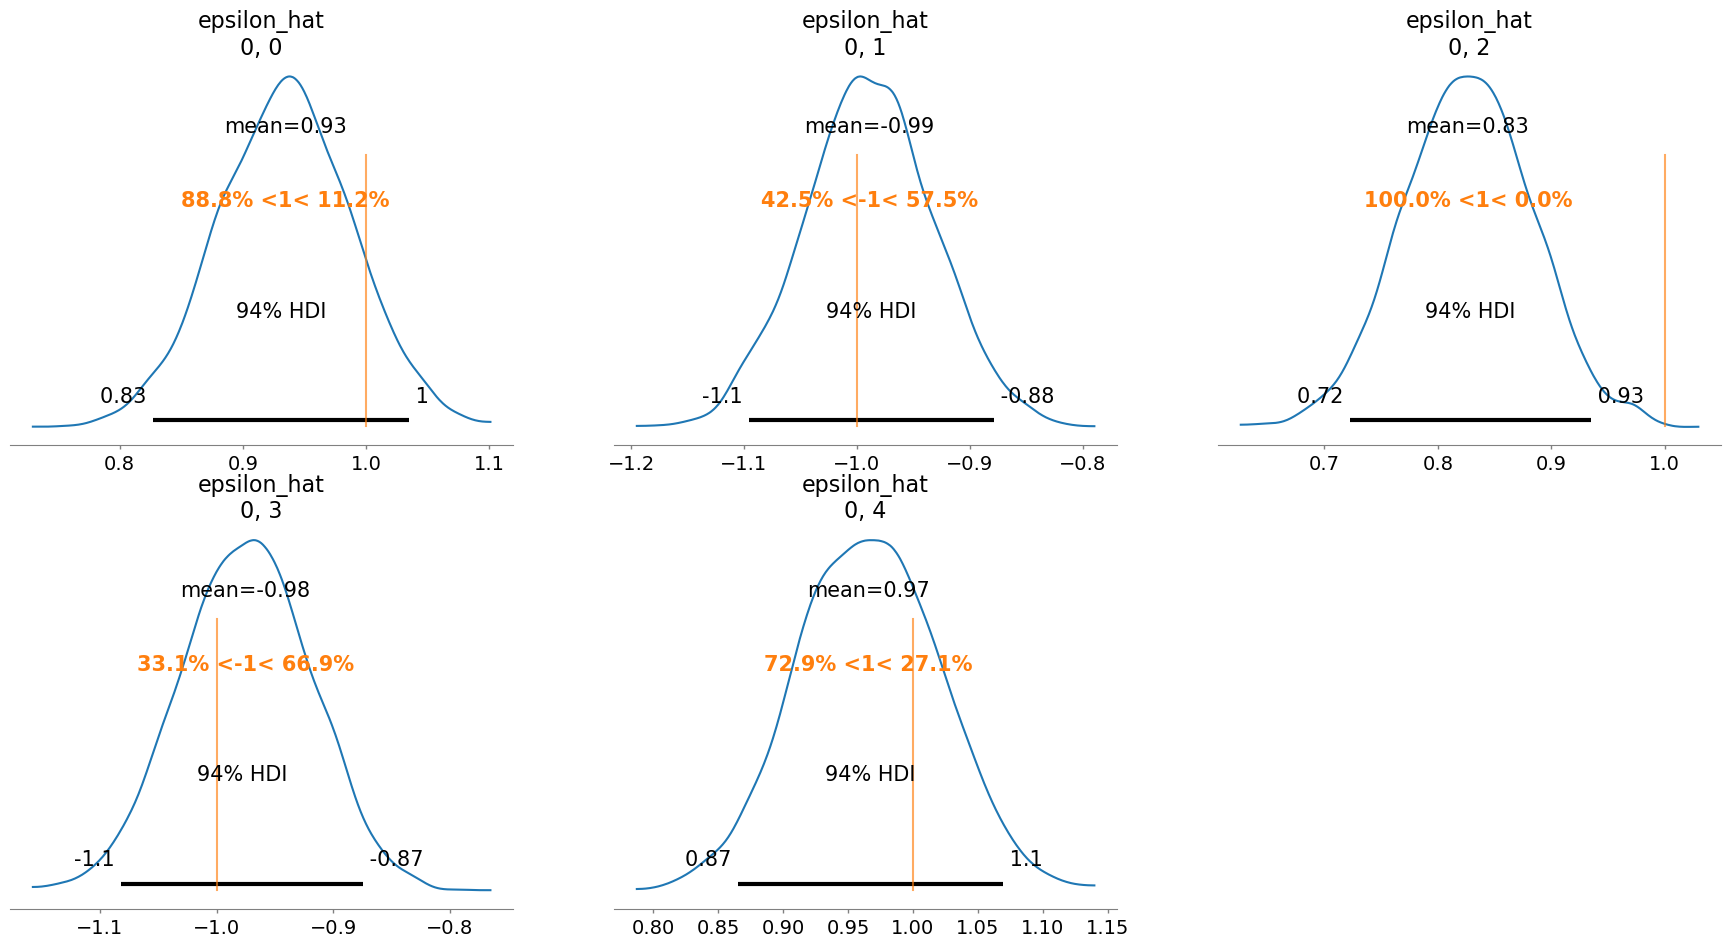

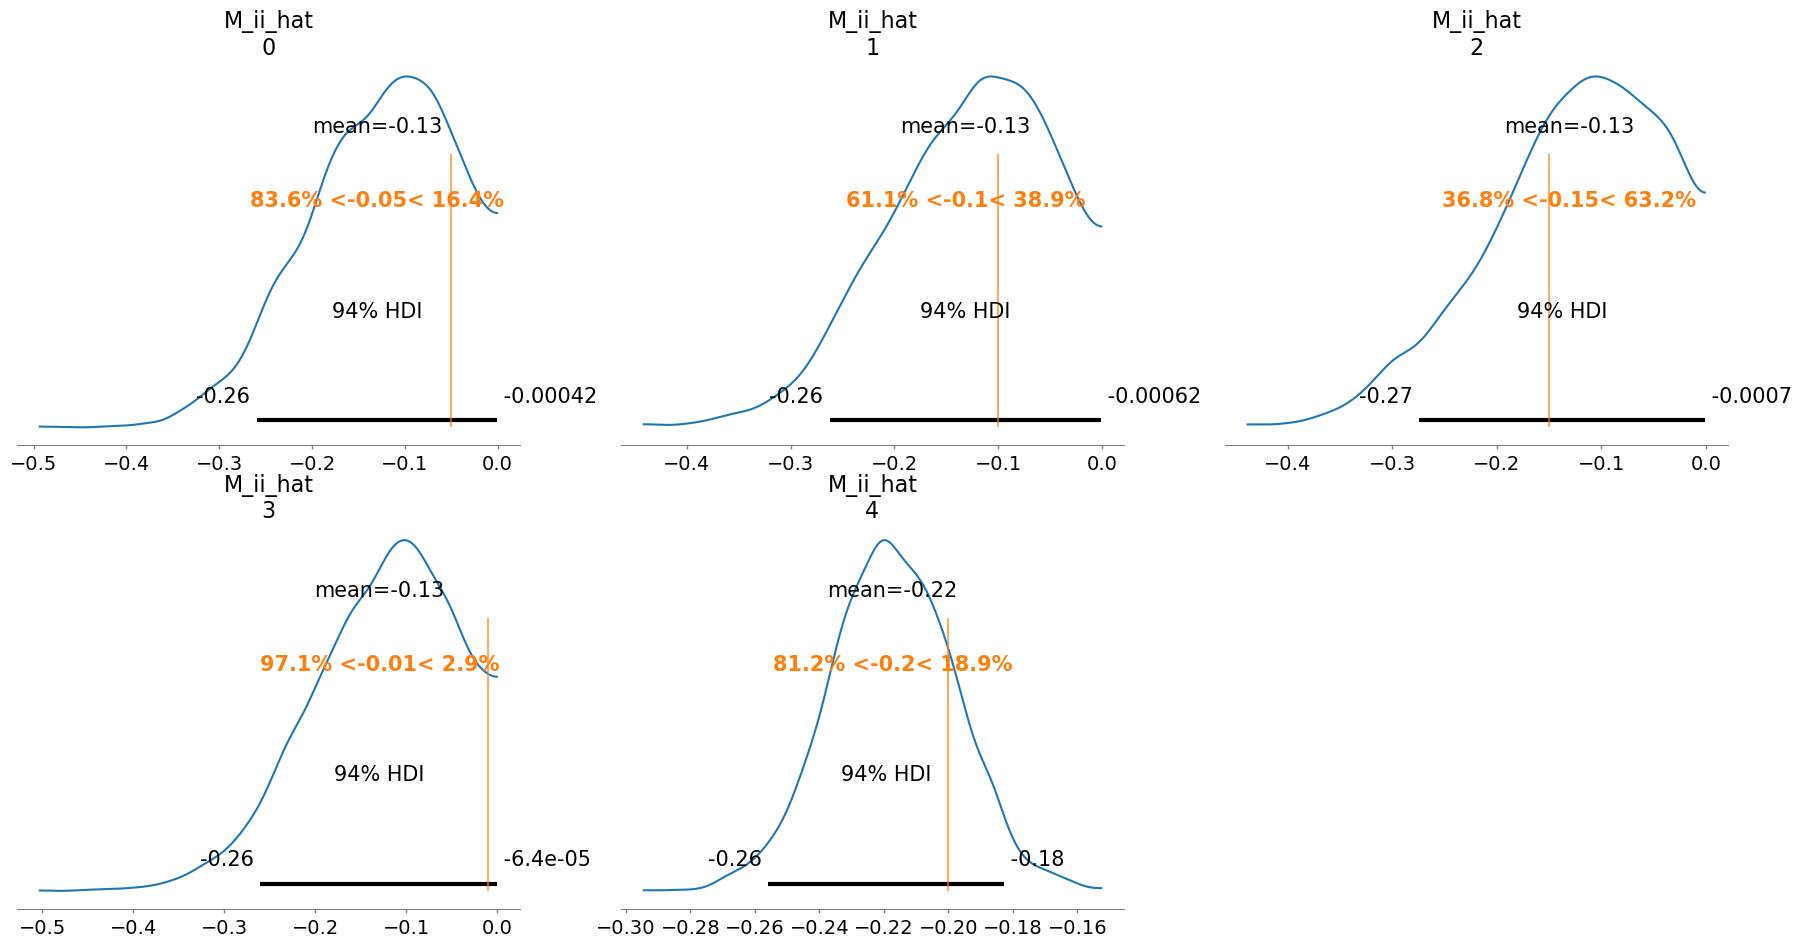

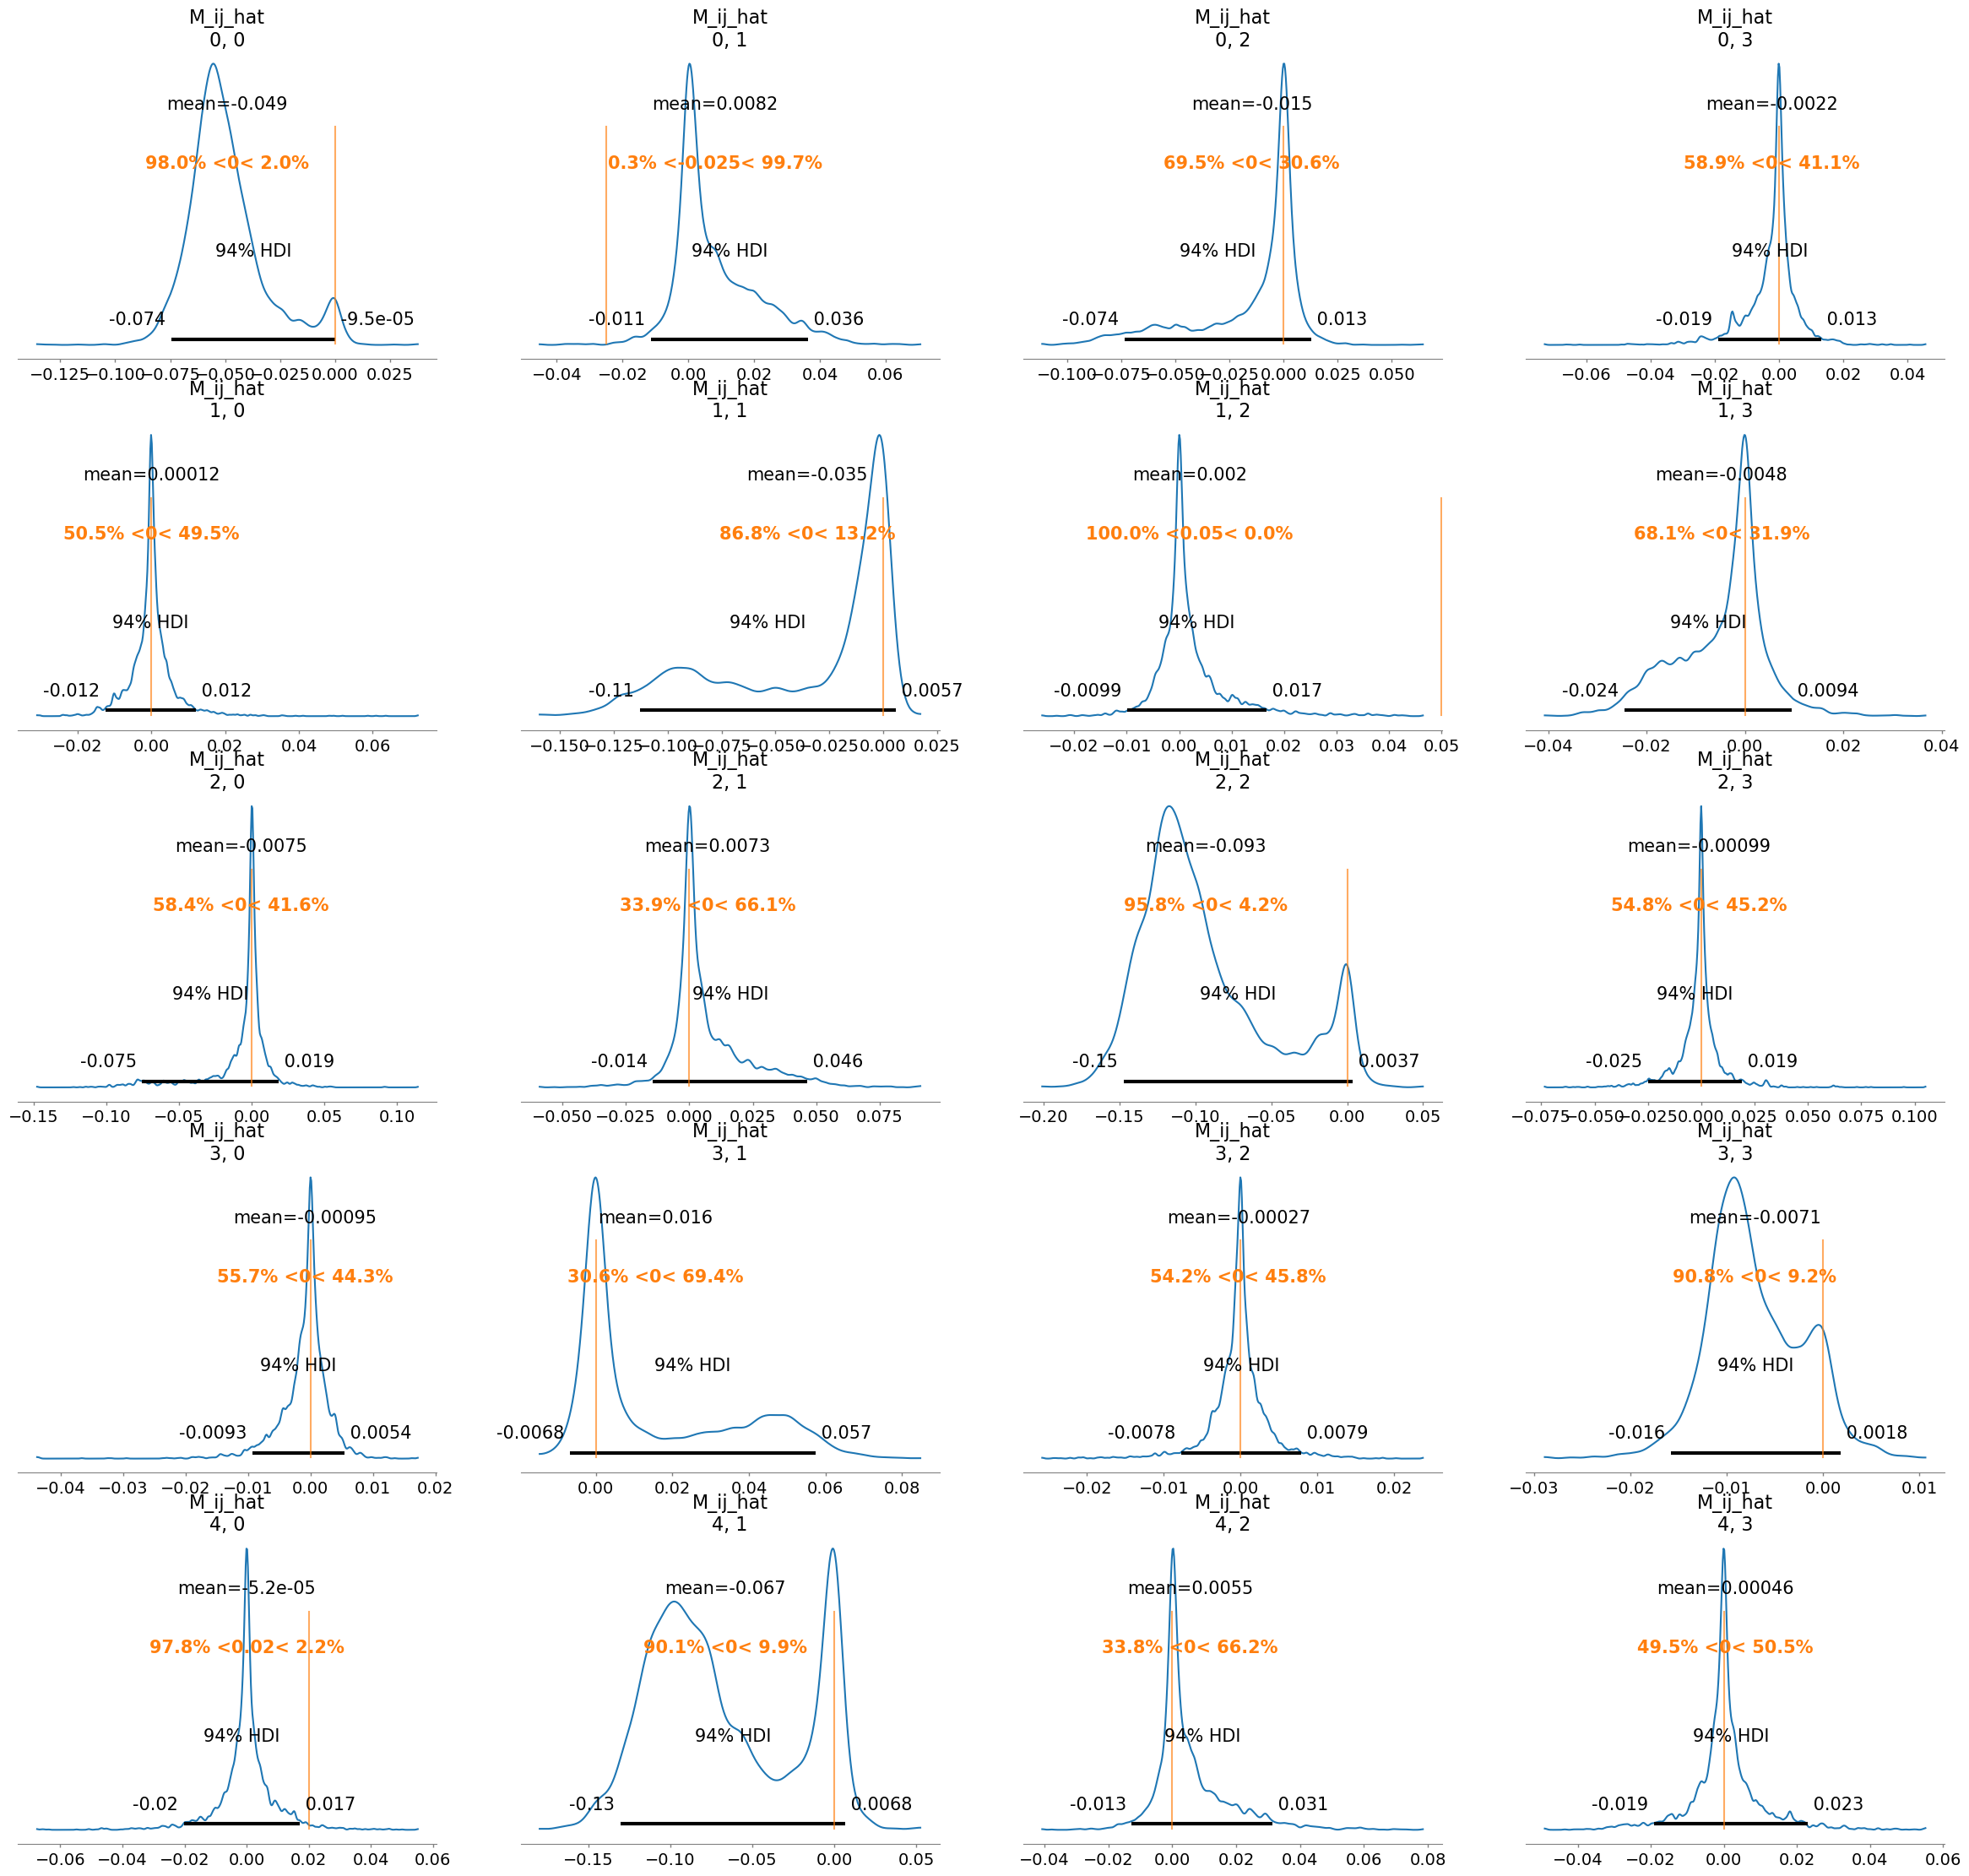

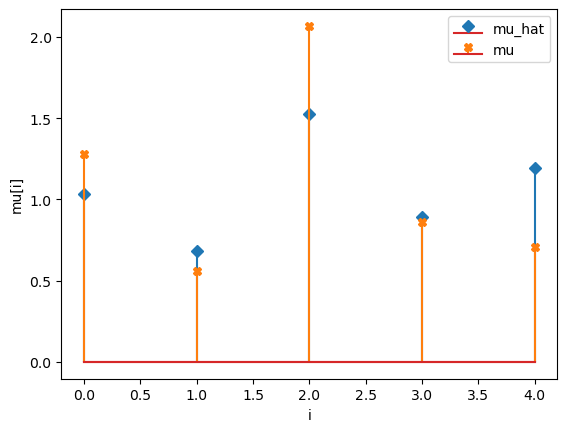

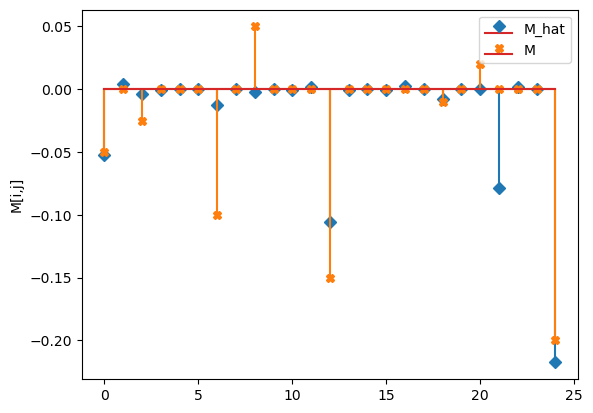

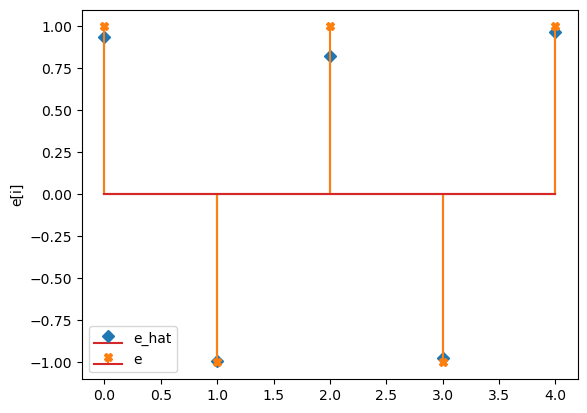

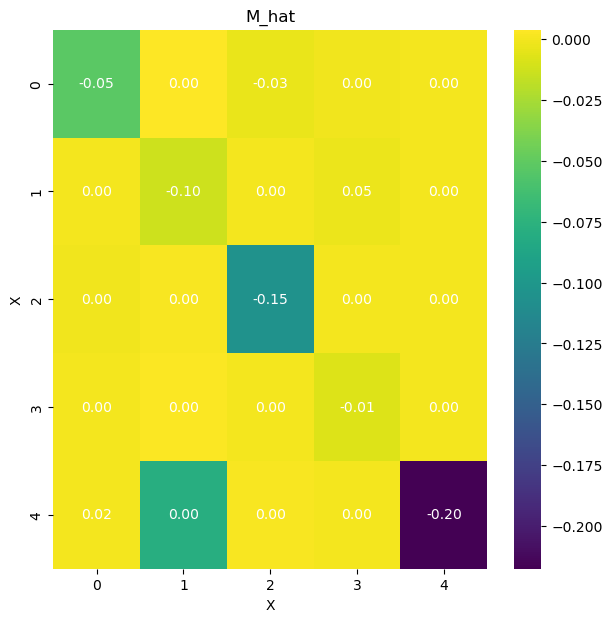

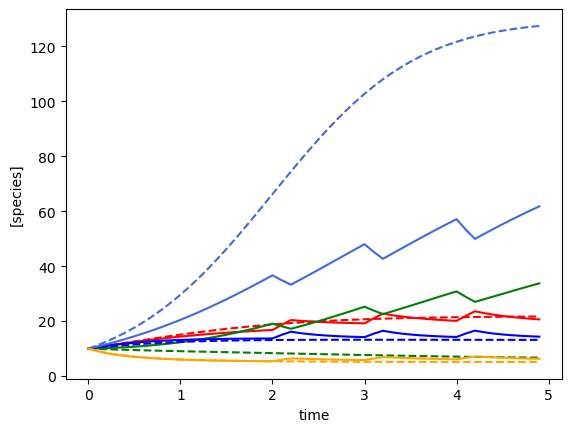

In [54]:
# read in posterior samples
idata = az.from_netcdf('model_posterior.nc')

az.plot_posterior(idata, var_names=["mu_hat"], ref_val=mu.flatten().tolist() )
plt.savefig("plot-posterior-mu.pdf")

az.plot_posterior(idata, var_names=["epsilon_hat"], ref_val=epsilon.flatten().tolist() )
plt.savefig("plot-posterior-eps.pdf")

az.plot_posterior(idata, var_names=["M_ii_hat"], ref_val=np.diag(M).tolist() )
plt.savefig("plot-posterior-Mii.pdf")

mask = ~np.eye(M.shape[0], dtype=bool)
M_ij = M[mask]
az.plot_posterior(idata, var_names=["M_ij_hat"], ref_val=M_ij.flatten().tolist() )
plt.savefig("plot-posterior-Mij.pdf")

# get posterior medians
M_h = np.median(idata.posterior["M_hat"].values, axis=(0,1))

mu_h = np.median(idata.posterior["mu_hat"].values, axis=(0, 1))
mu_h = mu_h.flatten()

e_h = np.median(idata.posterior["epsilon_hat"].values, axis=(0, 1))
# reshape e_h so it is the same shape as epsilon
e_h = e_h.reshape(epsilon.shape)

# compare median posterior values to true values
compare_params(mu=(mu, mu_h), M=(M, M_h), e=(epsilon, e_h))

# visualize the interaction matrix
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sns.heatmap(M_h, ax=ax, cmap='viridis')
ax.set_title('M_hat')
ax.set_ylabel('X')
ax.set_xlabel('X')
# Annotate the true values 
for i in range(M_h.shape[0]):
    for j in range(M_h.shape[1]):
        ax.text(j + 0.5, i + 0.5, f'{M[i, j]:.2f}', ha='center', va='center', color='white')


# Look at fit
predictor = sim_gLV(num_species=num_species,
                    num_perturbations=num_perturbations,
                    M=M_h,
                    mu=mu_h,
                    epsilon=e_h)

print('epsilon:', epsilon)
print('epsilon_h:', e_h)

yobs, init_species, mu, M, _  = simulator.simulate(times=times, init_species=init_species, u=pert_fn)
plot_fit_gLV(yobs, yobs_h, times)
